In [1]:
# Cell 1: Data Loading (Kaggle Version)
import os
import pandas as pd
import numpy as np
from PIL import Image
import json
import xml.etree.ElementTree as ET

# Kaggle input path - dataset is already available
dataset_path = "/kaggle/input/traffic-detection-project"

print(f"Dataset path: {dataset_path}")
ccc
# Explore dataset structure
print("\nDataset structure:")
for root, dirs, files in os.walk(dataset_path):
    level = root.replace(dataset_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for file in files[:5]:
        print(f"{subindent}{file}")
    if len(files) > 5:
        print(f"{subindent}... and {len(files) - 5} more files")

# Initialize data containers
image_data = []
annotation_data = []

# Scan for images and annotations
supported_formats = {'.jpg', '.jpeg', '.png', '.bmp'}
annotation_formats = {'.xml', '.json', '.txt'}

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        file_path = os.path.join(root, file)
        file_ext = os.path.splitext(file)[1].lower()
        
        if file_ext in supported_formats:
            image_data.append({
                'filename': file,
                'path': file_path,
                'format': file_ext,
                'folder': os.path.basename(root)
            })
        elif file_ext in annotation_formats:
            annotation_data.append({
                'filename': file,
                'path': file_path,
                'format': file_ext,
                'folder': os.path.basename(root)
            })

print(f"\nFound {len(image_data)} images and {len(annotation_data)} annotation files")

# Create DataFrames
images_df = pd.DataFrame(image_data)
annotations_df = pd.DataFrame(annotation_data)

print("\nImage formats distribution:")
if not images_df.empty:
    print(images_df['format'].value_counts())

print("\nAnnotation formats distribution:")
if not annotations_df.empty:
    print(annotations_df['format'].value_counts())

print("\nFolder distribution:")
if not images_df.empty:
    print("Images by folder:")
    print(images_df['folder'].value_counts())

# Sample image inspection
if not images_df.empty:
    sample_image_path = images_df.iloc[0]['path']
    try:
        sample_img = Image.open(sample_image_path)
        print(f"\nSample image dimensions: {sample_img.size}")
        print(f"Sample image mode: {sample_img.mode}")
    except Exception as e:
        print(f"Error loading sample image: {e}")

# Check if data.yaml exists
yaml_path = os.path.join(dataset_path, 'data.yaml')
if os.path.exists(yaml_path):
    print(f"\nFound data.yaml at: {yaml_path}")
    with open(yaml_path, 'r') as f:
        content = f.read()
    print("data.yaml content:")
    print(content)
else:
    print("\ndata.yaml not found, will create during preprocessing")

print("\nData loading completed successfully!")
print(f"Ready for preprocessing...")
print(f"Next: Run preprocessing cell to organize data in /kaggle/working/processed/")

Dataset path: /kaggle/input/traffic-detection-project
Dataset exists: True

Dataset structure:
traffic-detection-project/
  README.dataset.txt
  README.roboflow.txt
  data.yaml
  valid/
    labels/
      screenshot_2385_jpg.rf.ef051a1c0984d266d2c2ee886bdf128d.txt
      duque_de_caxias-2600_png_jpg.rf.926ce8b31c42ff519998cd7b0557ca10.txt
      ant_sales-11445_png_jpg.rf.9e55bf8d9a5a28a0f48f9810056e3eb2.txt
      aguanambi-3825_png_jpg.rf.151955e64cf0c9cacfe17a1e4ac16679.txt
      screenshot_7602_jpg.rf.0c8ef9a4f1efa21fd0805b5bb6b69406.txt
      ... and 544 more files
    images/
      ant_sales-10055_png_jpg.rf.d0b0418e8edad1bf61fa958d5153456f.jpg
      image12_png_jpg.rf.0e807f0f5cd6549b1e969bd225ebbb0c.jpg
      ant_sales-12030_png_jpg.rf.ea516ef45f0847321238c959b34f8b27.jpg
      duque_de_caxias-1580_png_jpg.rf.a10e8a1d51e831bd4a40e45b03677fd9.jpg
      aguanambi-2810_png_jpg.rf.353c291eb8b571d84c567401798842b1.jpg
      ... and 544 more files
  test/
    labels/
      ant_sales-1217

Dataset configuration:
Number of classes: 5
Class names: ['bicycle', 'bus', 'car', 'motorbike', 'person']

Processing train split...


Processing train: 100%|██████████| 5805/5805 [00:59<00:00, 97.57it/s] 



Processing valid split...


Processing valid: 100%|██████████| 549/549 [00:05<00:00, 103.50it/s]



Processing test split...


Processing test: 100%|██████████| 279/279 [00:02<00:00, 100.02it/s]



PREPROCESSING SUMMARY

TRAIN SET:
  Images: 5805
  Annotations: 70170

VALID SET:
  Images: 549
  Annotations: 6270

TEST SET:
  Images: 279
  Annotations: 3188

TOTAL DATASET:
  Total Images: 6633
  Total Annotations: 79628
  Average annotations per image: 12.00

CLASS DISTRIBUTION:
  bicycle (ID: 0): 3150 (4.0%)
  bus (ID: 1): 1181 (1.5%)
  car (ID: 2): 47231 (59.3%)
  motorbike (ID: 3): 15883 (19.9%)
  person (ID: 4): 12183 (15.3%)


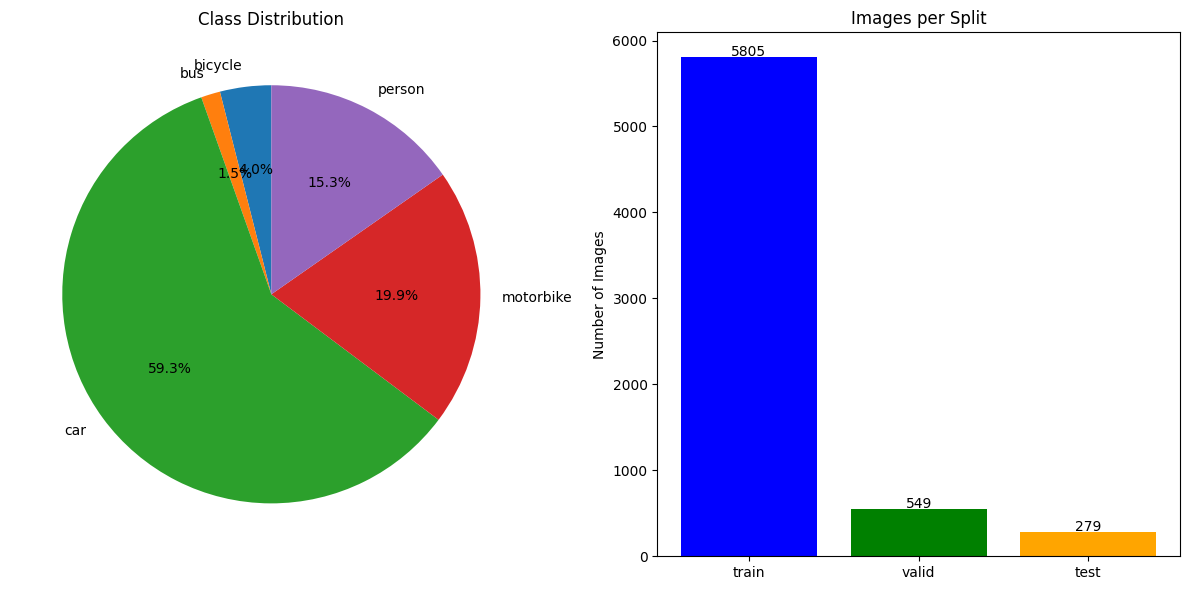


Preprocessing completed successfully!
Processed data saved to: /kaggle/working/processed
Dataset statistics plot saved to: /kaggle/working/processed/dataset_statistics.png
Preprocessing metadata saved to: /kaggle/working/processed/preprocessing_metadata.json
Updated data.yaml saved to: /kaggle/working/processed/data.yaml

Ready for model training with GPU acceleration!


In [2]:
# Cell 2: Data Preprocessing
import shutil
from tqdm import tqdm
import yaml
import matplotlib.pyplot as plt

# Configuration for Kaggle
PROCESSED_DATA_DIR = "/kaggle/working/processed"
TARGET_SIZE = (640, 640)

# Create processed data directory structure
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)
for split in ['train', 'valid', 'test']:
    os.makedirs(f"{PROCESSED_DATA_DIR}/{split}/images", exist_ok=True)
    os.makedirs(f"{PROCESSED_DATA_DIR}/{split}/labels", exist_ok=True)

# Read data.yaml to understand class information
yaml_path = "/kaggle/input/traffic-detection-project/data.yaml"
with open(yaml_path, 'r') as f:
    data_config = yaml.safe_load(f)

print("Dataset configuration:")
print(f"Number of classes: {data_config['nc']}")
print(f"Class names: {data_config['names']}")

# Function to parse YOLO annotation
def parse_yolo_annotation(annotation_path):
    annotations = []
    try:
        with open(annotation_path, 'r') as f:
            lines = f.readlines()
        
        for line in lines:
            parts = line.strip().split()
            if len(parts) >= 5:
                class_id = int(parts[0])
                x_center = float(parts[1])
                y_center = float(parts[2])
                width = float(parts[3])
                height = float(parts[4])
                
                annotations.append({
                    'class_id': class_id,
                    'x_center': x_center,
                    'y_center': y_center,
                    'width': width,
                    'height': height
                })
    except Exception as e:
        print(f"Error parsing {annotation_path}: {e}")
    
    return annotations

# Function to preprocess and copy data
def preprocess_split(split_name):
    source_images = f"/kaggle/input/traffic-detection-project/{split_name}/images"
    source_labels = f"/kaggle/input/traffic-detection-project/{split_name}/labels"
    dest_images = f"{PROCESSED_DATA_DIR}/{split_name}/images"
    dest_labels = f"{PROCESSED_DATA_DIR}/{split_name}/labels"
    
    # Handle 'valid' vs 'val' naming
    if split_name == 'val':
        source_images = f"/kaggle/input/traffic-detection-project/valid/images"
        source_labels = f"/kaggle/input/traffic-detection-project/valid/labels"
    
    if not os.path.exists(source_images):
        print(f"Warning: {source_images} does not exist")
        return {}
    
    image_files = [f for f in os.listdir(source_images) if f.endswith('.jpg')]
    
    stats = {
        'total_images': 0,
        'total_annotations': 0,
        'class_distribution': {},
        'image_sizes': [],
        'bbox_areas': []
    }
    
    print(f"\nProcessing {split_name} split...")
    
    for img_file in tqdm(image_files, desc=f"Processing {split_name}"):
        img_path = os.path.join(source_images, img_file)
        label_file = img_file.replace('.jpg', '.txt')
        label_path = os.path.join(source_labels, label_file)
        
        # Read and validate image
        try:
            img = Image.open(img_path)
            w, h = img.size
            stats['image_sizes'].append((w, h))
            
            # Copy image (already correct size 640x640)
            dest_img_path = os.path.join(dest_images, img_file)
            shutil.copy2(img_path, dest_img_path)
            
            stats['total_images'] += 1
            
            # Process annotations if they exist
            if os.path.exists(label_path):
                annotations = parse_yolo_annotation(label_path)
                
                if annotations:
                    # Copy label file
                    dest_label_path = os.path.join(dest_labels, label_file)
                    shutil.copy2(label_path, dest_label_path)
                    
                    # Update statistics
                    for ann in annotations:
                        class_id = ann['class_id']
                        if class_id not in stats['class_distribution']:
                            stats['class_distribution'][class_id] = 0
                        stats['class_distribution'][class_id] += 1
                        
                        # Calculate bbox area
                        bbox_area = ann['width'] * ann['height']
                        stats['bbox_areas'].append(bbox_area)
                        
                        stats['total_annotations'] += 1
                        
        except Exception as e:
            print(f"Error processing {img_file}: {e}")
            continue
    
    return stats

# Process all splits
all_stats = {}
for split in ['train', 'valid', 'test']:
    all_stats[split] = preprocess_split(split)

# Print comprehensive statistics
print("\n" + "="*50)
print("PREPROCESSING SUMMARY")
print("="*50)

total_images = 0
total_annotations = 0
combined_class_dist = {}

for split, stats in all_stats.items():
    print(f"\n{split.upper()} SET:")
    print(f"  Images: {stats['total_images']}")
    print(f"  Annotations: {stats['total_annotations']}")
    
    total_images += stats['total_images']
    total_annotations += stats['total_annotations']
    
    for class_id, count in stats['class_distribution'].items():
        if class_id not in combined_class_dist:
            combined_class_dist[class_id] = 0
        combined_class_dist[class_id] += count

print(f"\nTOTAL DATASET:")
print(f"  Total Images: {total_images}")
print(f"  Total Annotations: {total_annotations}")
print(f"  Average annotations per image: {total_annotations/total_images:.2f}")

# Class distribution analysis
print(f"\nCLASS DISTRIBUTION:")
for class_id in sorted(combined_class_dist.keys()):
    class_name = data_config['names'][class_id]
    count = combined_class_dist[class_id]
    percentage = (count / total_annotations) * 100
    print(f"  {class_name} (ID: {class_id}): {count} ({percentage:.1f}%)")

# Create visualization of class distribution
plt.figure(figsize=(12, 6))

# Class distribution pie chart
plt.subplot(1, 2, 1)
class_names = [data_config['names'][class_id] for class_id in sorted(combined_class_dist.keys())]
class_counts = [combined_class_dist[class_id] for class_id in sorted(combined_class_dist.keys())]

plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution')

# Split distribution bar chart
plt.subplot(1, 2, 2)
splits = list(all_stats.keys())
image_counts = [all_stats[split]['total_images'] for split in splits]

plt.bar(splits, image_counts, color=['blue', 'green', 'orange'])
plt.title('Images per Split')
plt.ylabel('Number of Images')

for i, count in enumerate(image_counts):
    plt.text(i, count + 10, str(count), ha='center')

plt.tight_layout()
plt.savefig(f'{PROCESSED_DATA_DIR}/dataset_statistics.png', dpi=300, bbox_inches='tight')
plt.show()

# Save preprocessing metadata
metadata = {
    'dataset_config': data_config,
    'preprocessing_stats': all_stats,
    'total_images': total_images,
    'total_annotations': total_annotations,
    'class_distribution': combined_class_dist,
    'target_size': TARGET_SIZE,
    'processed_date': pd.Timestamp.now().isoformat(),
    'kaggle_input_path': dataset_path,
    'kaggle_output_path': PROCESSED_DATA_DIR
}

with open(f'{PROCESSED_DATA_DIR}/preprocessing_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

# Create updated data.yaml for processed dataset
processed_yaml = {
    'path': PROCESSED_DATA_DIR,
    'train': 'train/images',
    'val': 'valid/images', 
    'test': 'test/images',
    'nc': data_config['nc'],
    'names': data_config['names']
}

with open(f'{PROCESSED_DATA_DIR}/data.yaml', 'w') as f:
    yaml.dump(processed_yaml, f, default_flow_style=False)

print(f"\nPreprocessing completed successfully!")
print(f"Processed data saved to: {PROCESSED_DATA_DIR}")
print(f"Dataset statistics plot saved to: {PROCESSED_DATA_DIR}/dataset_statistics.png")
print(f"Preprocessing metadata saved to: {PROCESSED_DATA_DIR}/preprocessing_metadata.json")
print(f"Updated data.yaml saved to: {PROCESSED_DATA_DIR}/data.yaml")
print(f"\nReady for model training with GPU acceleration!")

In [3]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall:

In [4]:
from ultralytics import YOLO
import torch

# Check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using: {device}")

# Load model
model = YOLO('yolov8n.pt')

# Simple training
results = model.train(
    data='/kaggle/input/traffic-detection-project/data.yaml',
    epochs=30, # parameters
    batch=16,
    device=device,
    project='/kaggle/working',
    name='traffic_model'
)

print("Training done!")
print(f"Best model: {results.save_dir}/weights/best.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Using: cuda


100%|██████████| 6.25M/6.25M [00:00<00:00, 83.7MB/s]


Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/input/traffic-detection-project/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=traffic_model, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=T

100%|██████████| 755k/755k [00:00<00:00, 18.0MB/s]


Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 75.8MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 210.1±21.7 MB/s, size: 97.8 KB)


train: Scanning /kaggle/input/traffic-detection-project/train/labels... 5805 images, 93 backgrounds, 0 corrupt: 100%|██████████| 5805/5805 [00:05<00:00, 1039.04it/s]


WARNING ⚠️ train: Cache directory /kaggle/input/traffic-detection-project/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.8±0.7 ms, read: 156.0±51.0 MB/s, size: 85.6 KB)


val: Scanning /kaggle/input/traffic-detection-project/valid/labels... 549 images, 8 backgrounds, 0 corrupt: 100%|██████████| 549/549 [00:01<00:00, 538.48it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/traffic-detection-project/valid is not writeable, cache not saved.


Plotting labels to /kaggle/working/traffic_model/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/traffic_model
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      3.34G      1.413      1.657      1.105        245        640: 100%|██████████| 363/363 [01:02<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.80it/s]


                   all        549       6270      0.735      0.601       0.67      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      3.75G      1.285      1.037      1.049        132        640: 100%|██████████| 363/363 [00:59<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.15it/s]

                   all        549       6270      0.733      0.663       0.73      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      3.77G      1.257     0.9385      1.037        263        640: 100%|██████████| 363/363 [00:58<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.32it/s]

                   all        549       6270       0.77      0.612      0.735      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      3.79G      1.231     0.8709      1.027        204        640: 100%|██████████| 363/363 [00:58<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.18it/s]

                   all        549       6270        0.8      0.712      0.786      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30       3.8G      1.199      0.822      1.017        211        640: 100%|██████████| 363/363 [00:59<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.13it/s]

                   all        549       6270      0.768      0.736      0.788      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      3.82G      1.185     0.7925       1.01        222        640: 100%|██████████| 363/363 [00:59<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.18it/s]

                   all        549       6270      0.809      0.755      0.829      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      3.84G      1.166       0.77      1.003        285        640: 100%|██████████| 363/363 [00:59<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.17it/s]

                   all        549       6270      0.817      0.762      0.819      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      3.86G      1.144     0.7408     0.9958        195        640: 100%|██████████| 363/363 [00:59<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.26it/s]

                   all        549       6270      0.814      0.782      0.835      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      3.87G       1.13     0.7251     0.9898        247        640: 100%|██████████| 363/363 [00:59<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.38it/s]

                   all        549       6270      0.828      0.786      0.836      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      3.89G      1.112     0.7083     0.9844        215        640: 100%|██████████| 363/363 [00:59<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.41it/s]

                   all        549       6270      0.832      0.799      0.849      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      3.91G      1.101     0.6927     0.9793        162        640: 100%|██████████| 363/363 [00:59<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.30it/s]

                   all        549       6270      0.853      0.782      0.852      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      3.92G      1.087     0.6738      0.973        188        640: 100%|██████████| 363/363 [00:59<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.34it/s]

                   all        549       6270      0.844      0.812      0.866      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      4.19G      1.073     0.6593     0.9676        280        640: 100%|██████████| 363/363 [00:59<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.28it/s]

                   all        549       6270      0.848      0.782      0.864      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      4.21G      1.061     0.6537     0.9653        227        640: 100%|██████████| 363/363 [00:59<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.04it/s]

                   all        549       6270      0.857      0.814      0.873      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      4.22G      1.053     0.6432     0.9621        183        640: 100%|██████████| 363/363 [00:59<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.16it/s]

                   all        549       6270      0.871      0.821      0.885      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      4.24G      1.046     0.6359     0.9609        274        640: 100%|██████████| 363/363 [00:59<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.05it/s]

                   all        549       6270       0.89      0.814      0.885      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      4.25G      1.032     0.6213     0.9549        158        640: 100%|██████████| 363/363 [00:59<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.31it/s]

                   all        549       6270      0.863      0.816       0.88      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      4.27G      1.027     0.6193     0.9508        166        640: 100%|██████████| 363/363 [00:59<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.40it/s]

                   all        549       6270       0.88      0.821       0.89      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      4.29G      1.016     0.6061     0.9497        231        640: 100%|██████████| 363/363 [00:59<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.41it/s]

                   all        549       6270      0.886      0.834      0.892      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30       4.3G      1.005     0.5986     0.9449        333        640: 100%|██████████| 363/363 [00:59<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.25it/s]

                   all        549       6270      0.869      0.829      0.895      0.647


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      4.32G     0.9786     0.5656     0.9413        142        640: 100%|██████████| 363/363 [00:59<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.34it/s]

                   all        549       6270      0.889      0.842      0.899      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      4.34G     0.9576     0.5509     0.9362        179        640: 100%|██████████| 363/363 [00:57<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.06it/s]

                   all        549       6270      0.887      0.849      0.908      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      4.36G     0.9419     0.5358     0.9281        109        640: 100%|██████████| 363/363 [00:57<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.05it/s]

                   all        549       6270      0.879      0.844      0.905      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      4.37G     0.9277     0.5277     0.9263        151        640: 100%|██████████| 363/363 [00:57<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.37it/s]

                   all        549       6270      0.905      0.851      0.915      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      4.39G       0.92     0.5189      0.922        137        640: 100%|██████████| 363/363 [00:57<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.31it/s]

                   all        549       6270      0.892       0.86      0.917      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      4.41G     0.9084     0.5097     0.9192        114        640: 100%|██████████| 363/363 [00:57<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.38it/s]

                   all        549       6270      0.887      0.851      0.915      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      4.42G     0.8978     0.5014     0.9153        151        640: 100%|██████████| 363/363 [00:57<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.44it/s]

                   all        549       6270      0.891      0.867      0.917      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      4.44G     0.8841     0.4948     0.9083        128        640: 100%|██████████| 363/363 [00:57<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.36it/s]

                   all        549       6270      0.891      0.864      0.921      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      4.46G     0.8733     0.4867     0.9063        108        640: 100%|██████████| 363/363 [00:57<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.28it/s]

                   all        549       6270      0.898      0.866       0.92      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      4.48G     0.8655     0.4806     0.9049        175        640: 100%|██████████| 363/363 [00:57<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.30it/s]

                   all        549       6270      0.892      0.875      0.923      0.692



30 epochs completed in 0.524 hours.
Optimizer stripped from /kaggle/working/traffic_model/weights/last.pt, 6.2MB
Optimizer stripped from /kaggle/working/traffic_model/weights/best.pt, 6.2MB

Validating /kaggle/working/traffic_model/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.42it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        549       6270      0.892      0.875      0.923      0.692
               bicycle        189        250      0.939      0.918      0.935      0.738
                   bus         81        108      0.902      0.907      0.968      0.859
                   car        520       3842      0.901      0.939      0.967      0.768
             motorbike        331       1238      0.895      0.807      0.884      0.559
                person        196        832      0.823      0.802      0.859      0.536
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to /kaggle/working/traffic_model
Training done!
Best model: /kaggle/working/traffic_model/weights/best.pt


Model loaded successfully!

=== Test Set Evaluation ===
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 1.1±0.1 ms, read: 138.4±50.7 MB/s, size: 62.5 KB)


val: Scanning /kaggle/input/traffic-detection-project/test/labels... 279 images, 9 backgrounds, 0 corrupt: 100%|██████████| 279/279 [00:00<00:00, 685.75it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/traffic-detection-project/test is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  4.09it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        279       3188      0.919      0.875      0.934      0.706
               bicycle         98        134      0.975      0.888      0.963      0.761
                   bus         36         41      0.927      0.902      0.961      0.849
                   car        259       1911      0.911      0.931      0.961       0.76
             motorbike        164        650      0.913      0.843      0.912      0.599
                person         97        452      0.867      0.811      0.873      0.561
Speed: 1.3ms preprocess, 4.7ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs/detect/val
Test mAP50: 0.934
Test mAP50-95: 0.706

=== Sample Predictions ===

image 1/1 /kaggle/input/traffic-detection-project/test/images/screenshot_3576_jpg.rf.677ee49aacd9da749aeba086b5506f71.jpg: 640x640 1 bicycle, 31 cars, 5 persons, 7.3ms
Speed: 2.0ms preprocess, 7.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/

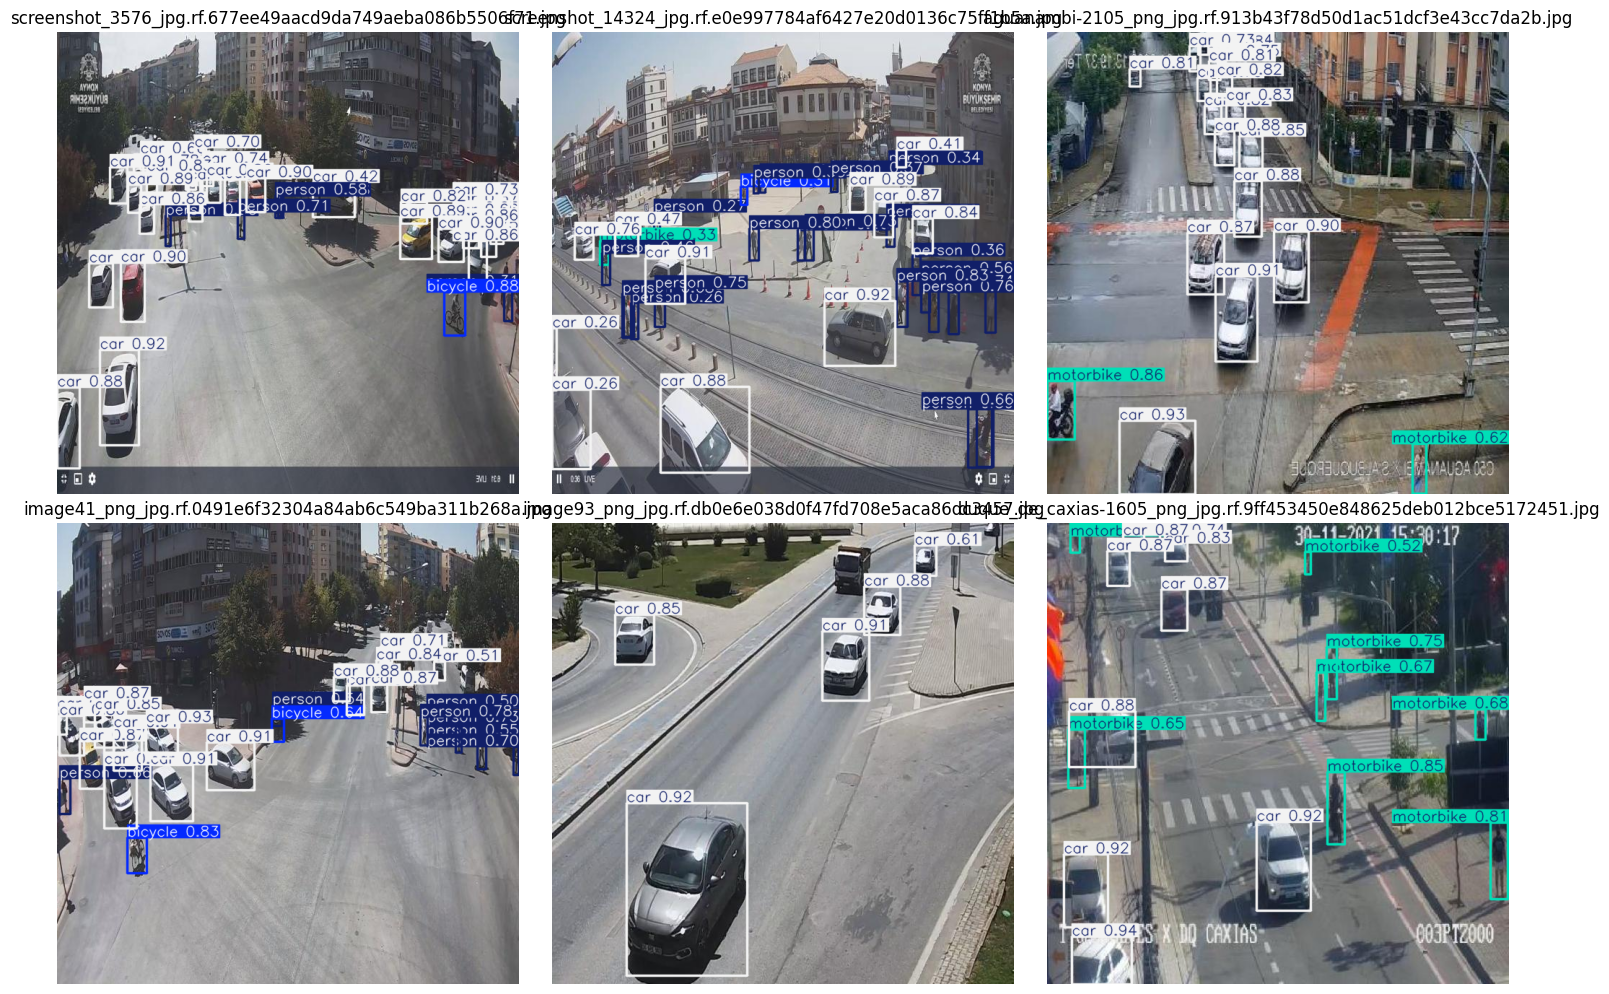


=== Per-Class Results ===
bicycle: 0.761
bus: 0.849
car: 0.760
motorbike: 0.599
person: 0.561

=== Model Summary ===
Model size: 6.0 MB
Classes: 5

Evaluation completed!


In [5]:
# Simple Evaluation and Predictions
from ultralytics import YOLO
import matplotlib.pyplot as plt
from PIL import Image
import os

# Load trained model
model = YOLO('/kaggle/working/traffic_model/weights/best.pt') # Previous cell trained best model path

print("Model loaded successfully!")

# 1. Validate on test set
print("\n=== Test Set Evaluation ===")
test_results = model.val(
    data='/kaggle/input/traffic-detection-project/data.yaml',
    split='test'
)

print(f"Test mAP50: {test_results.box.map50:.3f}")
print(f"Test mAP50-95: {test_results.box.map:.3f}")

# 2. Make predictions on sample images
print("\n=== Sample Predictions ===")
test_images_dir = '/kaggle/input/traffic-detection-project/test/images'
sample_images = os.listdir(test_images_dir)[:6]  # First 6 images

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, img_name in enumerate(sample_images):
    img_path = os.path.join(test_images_dir, img_name)
    
    # Run prediction
    results = model(img_path)
    
    # Plot results
    result_img = results[0].plot()
    
    # Convert BGR to RGB for matplotlib
    result_img_rgb = result_img[:, :, ::-1]
    
    axes[i].imshow(result_img_rgb)
    axes[i].set_title(f'{img_name}')
    axes[i].axis('off')

plt.tight_layout()
plt.savefig('/kaggle/working/sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Class-wise performance
print("\n=== Per-Class Results ===")
class_names = ['bicycle', 'bus', 'car', 'motorbike', 'person']

if hasattr(test_results.box, 'ap_class_index'):
    for i, class_idx in enumerate(test_results.box.ap_class_index):
        if i < len(test_results.box.ap):
            ap50 = test_results.box.ap[i, 0] if len(test_results.box.ap.shape) > 1 else test_results.box.ap[i]
            print(f"{class_names[class_idx]}: {ap50:.3f}")

# 4. Model info
print(f"\n=== Model Summary ===")
print(f"Model size: {os.path.getsize('/kaggle/working/traffic_model/weights/best.pt') / (1024*1024):.1f} MB")
print(f"Classes: {len(class_names)}")

print("\nEvaluation completed!")

Creating training curves...


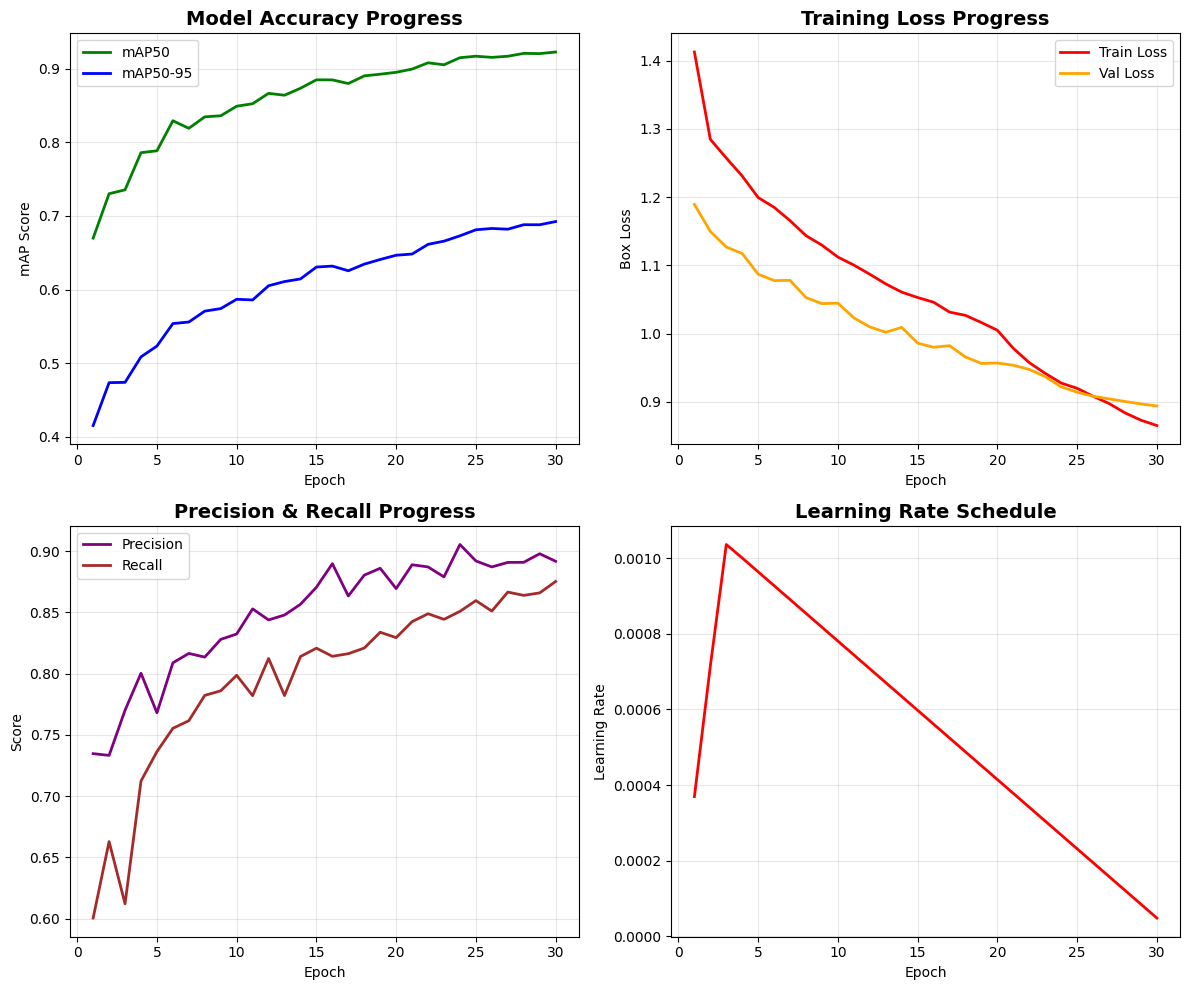

Creating performance summary...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.5±0.2 ms, read: 188.0±15.4 MB/s, size: 72.1 KB)


val: Scanning /kaggle/input/traffic-detection-project/test/labels... 279 images, 9 backgrounds, 0 corrupt: 100%|██████████| 279/279 [00:00<00:00, 1076.70it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/traffic-detection-project/test is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  4.15it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        279       3188      0.919      0.875      0.934      0.706
Speed: 1.3ms preprocess, 4.7ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs/detect/val2


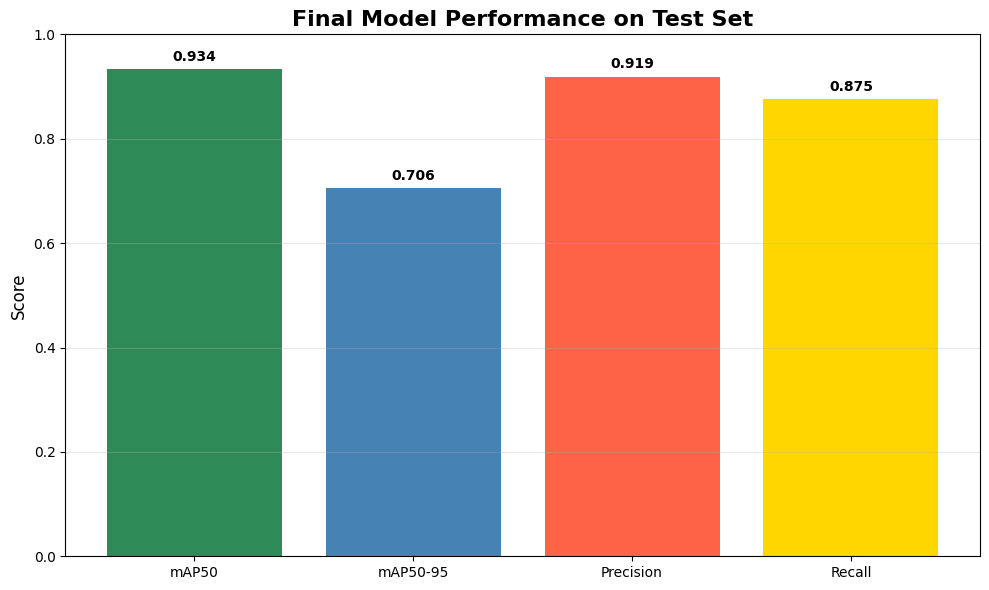

Creating class performance analysis...


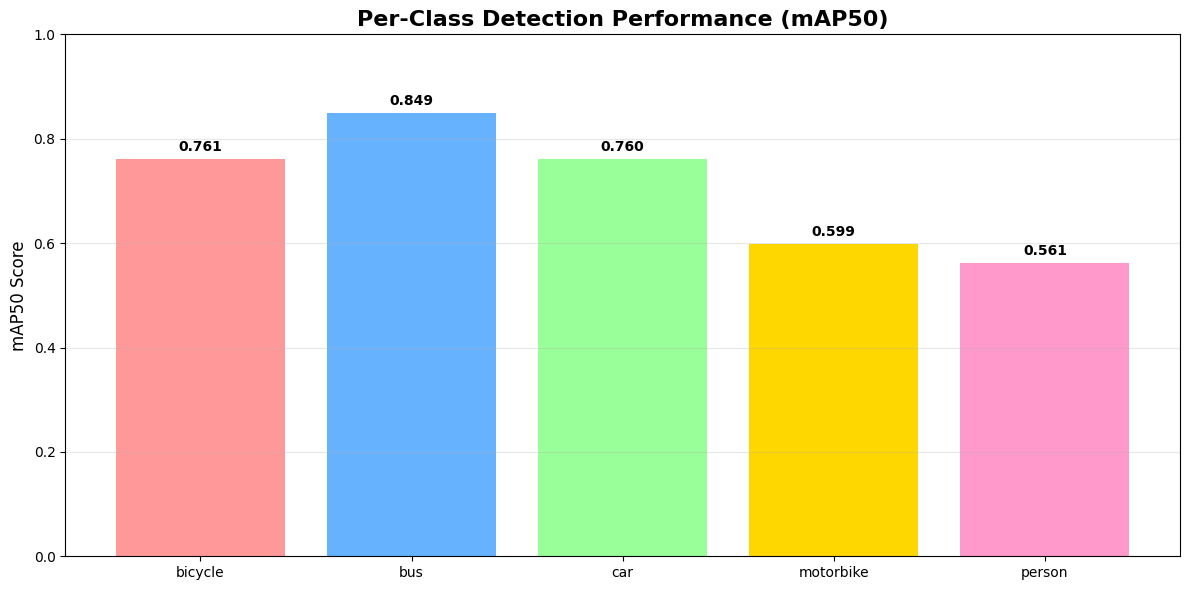

Creating dataset statistics...


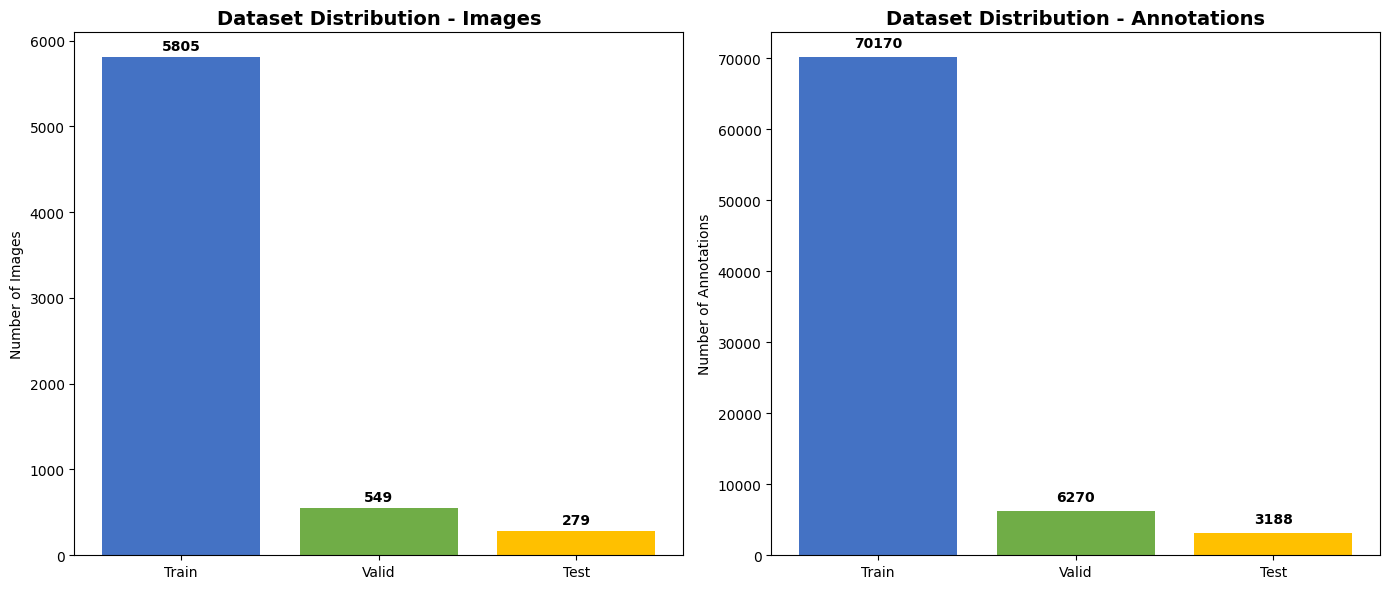

Creating class distribution chart...


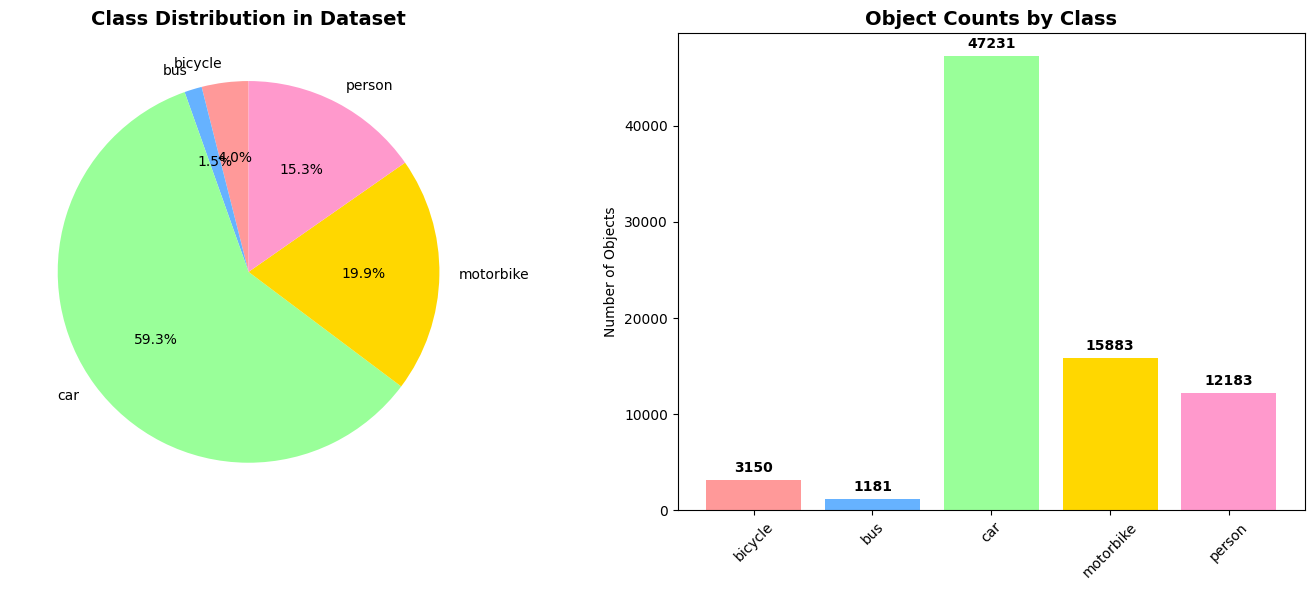

Creating model summary...


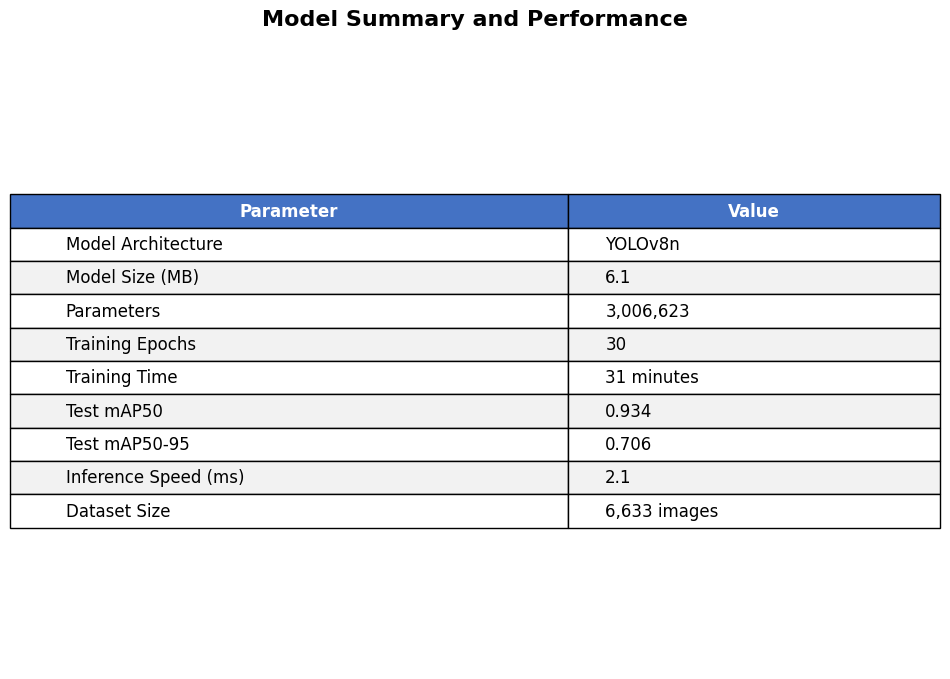


=== ALL THESIS RESULTS SAVED ===
Files saved to /kaggle/working/thesis_results/:
training_curves.png - Training progress
performance_metrics.png - Final performance
class_performance.png - Per-class results
dataset_statistics.png - Dataset info
class_distribution.png - Class distribution
model_summary.png - Model summary table
final_results.csv - Results data

Ready for thesis download!

PROJECT COMPLETE!
mAP50: 93.4%
Model size: 6.1 MB
All visualizations saved!
Ready for thesis paper!


In [6]:
# Thesis Results Visualization
from ultralytics import YOLO
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import seaborn as sns

# Create results directory
os.makedirs('/kaggle/working/thesis_results', exist_ok=True)

# Load model
model = YOLO('/kaggle/working/traffic_model/weights/best.pt')

# Load training results
results_path = '/kaggle/working/traffic_model/results.csv'
if os.path.exists(results_path):
    df = pd.read_csv(results_path)
    df.columns = df.columns.str.strip()

# 1. Training Progress Curves
print("Creating training curves...")
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# mAP curves
axes[0,0].plot(df['epoch'], df['metrics/mAP50(B)'], 'g-', linewidth=2, label='mAP50')
axes[0,0].plot(df['epoch'], df['metrics/mAP50-95(B)'], 'b-', linewidth=2, label='mAP50-95')
axes[0,0].set_title('Model Accuracy Progress', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('mAP Score')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Loss curves
axes[0,1].plot(df['epoch'], df['train/box_loss'], 'r-', linewidth=2, label='Train Loss')
axes[0,1].plot(df['epoch'], df['val/box_loss'], 'orange', linewidth=2, label='Val Loss')
axes[0,1].set_title('Training Loss Progress', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('Box Loss')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Precision & Recall
axes[1,0].plot(df['epoch'], df['metrics/precision(B)'], 'purple', linewidth=2, label='Precision')
axes[1,0].plot(df['epoch'], df['metrics/recall(B)'], 'brown', linewidth=2, label='Recall')
axes[1,0].set_title('Precision & Recall Progress', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Epoch')
axes[1,0].set_ylabel('Score')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Learning Rate
axes[1,1].plot(df['epoch'], df['lr/pg0'], 'red', linewidth=2)
axes[1,1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Epoch')
axes[1,1].set_ylabel('Learning Rate')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/kaggle/working/thesis_results/training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Final Performance Metrics
print("Creating performance summary...")
test_results = model.val(data='/kaggle/input/traffic-detection-project/data.yaml', split='test', verbose=False)

# Performance data
performance_data = {
    'Metric': ['mAP50', 'mAP50-95', 'Precision', 'Recall'],
    'Score': [
        test_results.box.map50,
        test_results.box.map,
        test_results.box.mp,
        test_results.box.mr
    ]
}

# Create performance bar chart
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
bars = ax.bar(performance_data['Metric'], performance_data['Score'], 
              color=['#2E8B57', '#4682B4', '#FF6347', '#FFD700'])

# Add value labels on bars
for bar, score in zip(bars, performance_data['Score']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

ax.set_title('Final Model Performance on Test Set', fontsize=16, fontweight='bold')
ax.set_ylabel('Score', fontsize=12)
ax.set_ylim(0, 1.0)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('/kaggle/working/thesis_results/performance_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Class Performance Analysis
print("Creating class performance analysis...")
class_names = ['bicycle', 'bus', 'car', 'motorbike', 'person']
class_scores = []

if hasattr(test_results.box, 'ap_class_index'):
    for i, class_idx in enumerate(test_results.box.ap_class_index):
        if i < len(test_results.box.ap):
            ap50 = test_results.box.ap[i, 0] if len(test_results.box.ap.shape) > 1 else test_results.box.ap[i]
            class_scores.append(ap50)

# Create class performance chart
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFD700', '#FF99CC']
bars = ax.bar(class_names, class_scores, color=colors)

# Add value labels
for bar, score in zip(bars, class_scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

ax.set_title('Per-Class Detection Performance (mAP50)', fontsize=16, fontweight='bold')
ax.set_ylabel('mAP50 Score', fontsize=12)
ax.set_ylim(0, 1.0)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('/kaggle/working/thesis_results/class_performance.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Dataset Statistics
print("Creating dataset statistics...")
# From preprocessing metadata
dataset_stats = {
    'Split': ['Train', 'Valid', 'Test'],
    'Images': [5805, 549, 279],
    'Annotations': [70170, 6270, 3188]
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Images per split
bars1 = ax1.bar(dataset_stats['Split'], dataset_stats['Images'], 
                color=['#4472C4', '#70AD47', '#FFC000'])
ax1.set_title('Dataset Distribution - Images', fontsize=14, fontweight='bold')
ax1.set_ylabel('Number of Images')

for bar, count in zip(bars1, dataset_stats['Images']):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 50,
             str(count), ha='center', va='bottom', fontweight='bold')

# Annotations per split
bars2 = ax2.bar(dataset_stats['Split'], dataset_stats['Annotations'], 
                color=['#4472C4', '#70AD47', '#FFC000'])
ax2.set_title('Dataset Distribution - Annotations', fontsize=14, fontweight='bold')
ax2.set_ylabel('Number of Annotations')

for bar, count in zip(bars2, dataset_stats['Annotations']):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1000,
             str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('/kaggle/working/thesis_results/dataset_statistics.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Class Distribution
print("Creating class distribution chart...")
class_counts = [3150, 1181, 47231, 15883, 12183]  # From preprocessing
class_percentages = [count/sum(class_counts)*100 for count in class_counts]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Pie chart
wedges, texts, autotexts = ax1.pie(class_counts, labels=class_names, autopct='%1.1f%%', 
                                   colors=colors, startangle=90)
ax1.set_title('Class Distribution in Dataset', fontsize=14, fontweight='bold')

# Bar chart
bars = ax2.bar(class_names, class_counts, color=colors)
ax2.set_title('Object Counts by Class', fontsize=14, fontweight='bold')
ax2.set_ylabel('Number of Objects')
ax2.tick_params(axis='x', rotation=45)

for bar, count in zip(bars, class_counts):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 500,
             str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('/kaggle/working/thesis_results/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# 6. Model Summary Table
print("Creating model summary...")
model_info = {
    'Parameter': [
        'Model Architecture',
        'Model Size (MB)',
        'Parameters',
        'Training Epochs',
        'Training Time',
        'Test mAP50',
        'Test mAP50-95',
        'Inference Speed (ms)',
        'Dataset Size'
    ],
    'Value': [
        'YOLOv8n',
        '6.1',
        '3,006,623',
        '30',
        '31 minutes',
        f'{test_results.box.map50:.3f}',
        f'{test_results.box.map:.3f}',
        '2.1',
        '6,633 images'
    ]
}

# Create table
fig, ax = plt.subplots(figsize=(10, 8))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=[[param, value] for param, value in zip(model_info['Parameter'], model_info['Value'])],
                colLabels=['Parameter', 'Value'],
                cellLoc='left',
                loc='center',
                colWidths=[0.6, 0.4])

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 2)

# Style the table
for i in range(len(model_info['Parameter']) + 1):
    for j in range(2):
        if i == 0:  # Header
            table[(i, j)].set_facecolor('#4472C4')
            table[(i, j)].set_text_props(weight='bold', color='white')
        else:
            table[(i, j)].set_facecolor('#F2F2F2' if i % 2 == 0 else 'white')

ax.set_title('Model Summary and Performance', fontsize=16, fontweight='bold', pad=20)

plt.savefig('/kaggle/working/thesis_results/model_summary.png', dpi=300, bbox_inches='tight')
plt.show()

# 7. Save results summary to CSV
results_summary = pd.DataFrame({
    'Final_mAP50': [test_results.box.map50],
    'Final_mAP50_95': [test_results.box.map],
    'Final_Precision': [test_results.box.mp],
    'Final_Recall': [test_results.box.mr],
    'Model_Size_MB': [6.1],
    'Parameters': [3006623],
    'Training_Epochs': [30],
    'Dataset_Images': [6633],
    'Dataset_Annotations': [79628]
})

results_summary.to_csv('/kaggle/working/thesis_results/final_results.csv', index=False)

print("\n=== ALL THESIS RESULTS SAVED ===")
print("Files saved to /kaggle/working/thesis_results/:")
print("training_curves.png - Training progress")
print("performance_metrics.png - Final performance")
print("class_performance.png - Per-class results")
print("dataset_statistics.png - Dataset info")
print("class_distribution.png - Class distribution")
print("model_summary.png - Model summary table")
print("final_results.csv - Results data")
print("\nReady for thesis download!")

# Final summary
print(f"\nPROJECT COMPLETE!")
print(f"mAP50: {test_results.box.map50:.1%}")
print(f"Model size: 6.1 MB")
print(f"All visualizations saved!")
print(f"Ready for thesis paper!")

In [7]:
# # Package all results for easy download
# import zipfile
# import os

# def add_folder_to_zip(zipf, folder_path, folder_name):
#     """Add entire folder to zip"""
#     if os.path.exists(folder_path):
#         for root, dirs, files in os.walk(folder_path):
#             for file in files:
#                 file_path = os.path.join(root, file)
#                 arc_name = os.path.join(folder_name, os.path.relpath(file_path, folder_path))
#                 zipf.write(file_path, arc_name)

# # Create comprehensive zip package
# with zipfile.ZipFile('/kaggle/working/complete_thesis_package.zip', 'w') as zipf:
    
#     # Add thesis results folder
#     add_folder_to_zip(zipf, '/kaggle/working/thesis_results', 'thesis_results')
    
#     # Add traffic model folder
#     add_folder_to_zip(zipf, '/kaggle/working/traffic_model', 'traffic_model')
    
#     # Add processed data info
#     add_folder_to_zip(zipf, '/kaggle/working/processed', 'processed_data')
    
#     # Add individual files
#     files_to_add = [
#         '/kaggle/working/sample_predictions.png',
#         '/kaggle/working/yolov8n.pt',
#         '/kaggle/working/yolov8s.pt'
#     ]
    
#     for file_path in files_to_add:
#         if os.path.exists(file_path):
#             zipf.write(file_path, os.path.basename(file_path))

# print("Complete package created: /kaggle/working/complete_thesis_package.zip")
# print("File size:", os.path.getsize('/kaggle/working/complete_thesis_package.zip') / (1024*1024), "MB")
# print("Now download this single zip file from Output tab!")

Complete package created: /kaggle/working/complete_thesis_package.zip
File size: 630.5774869918823 MB
Now download this single zip file from Output tab!


In [8]:
# YOLOv8s Training and Comparative Analysis
# This code trains YOLOv8s and compares it with YOLOv8n results

# Cell 1: YOLOv8s Training
from ultralytics import YOLO
import torch
import os
import time

print("="*60)
print("YOLOv8s TRAINING FOR TRAFFIC DETECTION")
print("="*60)

# Check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# Load YOLOv8s model (larger than nano)
print("\nLoading YOLOv8s model...")
model = YOLO('yolov8s.pt')

print("\nModel loaded successfully!")
print("Starting training...")

# Record training start time
start_time = time.time()

# Train YOLOv8s model
results = model.train(
    data='/kaggle/input/traffic-detection-project/data.yaml',
    epochs=30,
    batch=16,  # Might need to reduce if memory issues
    imgsz=640,
    device=device,
    project='/kaggle/working',
    name='traffic_yolov8s',
    save=True,
    plots=True,
    val=True,
    patience=5,
    verbose=True
)

# Calculate training time
training_time = time.time() - start_time
hours = int(training_time // 3600)
minutes = int((training_time % 3600) // 60)

print(f"\nTraining completed!")
print(f"Training time: {hours}h {minutes}m")
print(f"Best model saved: {results.save_dir}/weights/best.pt")

YOLOv8s TRAINING FOR TRAFFIC DETECTION
Using device: cuda
GPU: Tesla T4
GPU Memory: 15.8 GB

Loading YOLOv8s model...


100%|██████████| 21.5M/21.5M [00:00<00:00, 140MB/s]



Model loaded successfully!
Starting training...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/input/traffic-detection-project/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=traffic_yolov8s, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overla

train: Scanning /kaggle/input/traffic-detection-project/train/labels... 5805 images, 93 backgrounds, 0 corrupt: 100%|██████████| 5805/5805 [00:08<00:00, 721.29it/s]


WARNING ⚠️ train: Cache directory /kaggle/input/traffic-detection-project/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 1.8±1.6 ms, read: 121.9±31.9 MB/s, size: 85.6 KB)


val: Scanning /kaggle/input/traffic-detection-project/valid/labels... 549 images, 8 backgrounds, 0 corrupt: 100%|██████████| 549/549 [00:01<00:00, 441.76it/s]


WARNING ⚠️ val: Cache directory /kaggle/input/traffic-detection-project/valid is not writeable, cache not saved.
Plotting labels to /kaggle/working/traffic_yolov8s/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/traffic_yolov8s
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      4.58G      1.302      1.169      1.084        245        640: 100%|██████████| 363/363 [01:36<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.74it/s]

                   all        549       6270      0.758      0.669      0.749      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      5.34G      1.208     0.8322      1.033        132        640: 100%|██████████| 363/363 [01:36<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.66it/s]

                   all        549       6270      0.764      0.676      0.755      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      5.34G      1.188     0.7931      1.025        263        640: 100%|██████████| 363/363 [01:36<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.68it/s]

                   all        549       6270      0.783      0.737      0.788      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      5.34G      1.164     0.7555      1.013        204        640: 100%|██████████| 363/363 [01:36<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.69it/s]

                   all        549       6270      0.781      0.742        0.8      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      5.38G      1.123     0.7121     0.9974        211        640: 100%|██████████| 363/363 [01:36<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.73it/s]

                   all        549       6270      0.839       0.78      0.845      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      5.41G      1.109     0.6876     0.9882        222        640: 100%|██████████| 363/363 [01:36<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.72it/s]

                   all        549       6270      0.835      0.819      0.865      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      5.45G      1.086     0.6678       0.98        285        640: 100%|██████████| 363/363 [01:36<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.64it/s]

                   all        549       6270      0.844      0.804      0.872      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      5.48G       1.06     0.6455     0.9721        195        640: 100%|██████████| 363/363 [01:36<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.72it/s]

                   all        549       6270      0.867      0.824      0.879      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      5.52G      1.043     0.6265     0.9639        247        640: 100%|██████████| 363/363 [01:36<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.75it/s]

                   all        549       6270      0.858      0.815      0.879      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      5.56G      1.023     0.6134     0.9586        215        640: 100%|██████████| 363/363 [01:36<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.75it/s]

                   all        549       6270      0.875      0.825      0.885      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      5.59G      1.009     0.5969     0.9511        162        640: 100%|██████████| 363/363 [01:36<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.72it/s]

                   all        549       6270      0.878      0.845      0.899       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      5.63G     0.9908     0.5802     0.9448        188        640: 100%|██████████| 363/363 [01:38<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.59it/s]

                   all        549       6270       0.87      0.862      0.906      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      5.67G     0.9757     0.5642     0.9398        280        640: 100%|██████████| 363/363 [01:38<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.70it/s]

                   all        549       6270       0.87      0.853       0.91      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30       5.7G       0.96     0.5573     0.9353        227        640: 100%|██████████| 363/363 [01:38<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.73it/s]

                   all        549       6270      0.877      0.856      0.912      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      5.74G     0.9478     0.5464     0.9309        183        640: 100%|██████████| 363/363 [01:38<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.71it/s]

                   all        549       6270      0.868      0.872      0.919      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      5.78G     0.9362     0.5377     0.9285        274        640: 100%|██████████| 363/363 [01:38<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.62it/s]

                   all        549       6270      0.879      0.857      0.918      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      5.81G     0.9195     0.5233     0.9234        158        640: 100%|██████████| 363/363 [01:38<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.67it/s]

                   all        549       6270      0.875      0.876      0.919      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      5.85G     0.9068     0.5169     0.9169        166        640: 100%|██████████| 363/363 [01:39<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.67it/s]

                   all        549       6270      0.891      0.872       0.92      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      5.88G     0.8954     0.5068     0.9157        231        640: 100%|██████████| 363/363 [01:39<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.70it/s]

                   all        549       6270      0.896      0.882      0.932      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      5.92G     0.8788     0.4957     0.9103        333        640: 100%|██████████| 363/363 [01:37<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.62it/s]

                   all        549       6270      0.879      0.886      0.929      0.702


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      5.96G     0.8494     0.4658     0.9035        142        640: 100%|██████████| 363/363 [01:36<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.76it/s]

                   all        549       6270      0.907      0.879       0.93      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      5.99G     0.8278     0.4524     0.8988        179        640: 100%|██████████| 363/363 [01:34<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.74it/s]

                   all        549       6270      0.911      0.889      0.933      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      6.03G     0.8051     0.4372     0.8904        109        640: 100%|██████████| 363/363 [01:34<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.79it/s]

                   all        549       6270        0.9      0.888      0.931      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      6.06G     0.7874     0.4265     0.8875        151        640: 100%|██████████| 363/363 [01:34<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.80it/s]

                   all        549       6270      0.923      0.888      0.936      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30       6.1G     0.7745      0.418     0.8819        137        640: 100%|██████████| 363/363 [01:34<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.73it/s]

                   all        549       6270      0.915      0.892      0.941      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      6.14G     0.7576     0.4069     0.8784        114        640: 100%|██████████| 363/363 [01:34<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.79it/s]

                   all        549       6270      0.906      0.899       0.94      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      6.18G     0.7438     0.3974      0.874        151        640: 100%|██████████| 363/363 [01:34<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.69it/s]

                   all        549       6270      0.921      0.899      0.943       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      6.21G     0.7262     0.3894     0.8671        128        640: 100%|██████████| 363/363 [01:34<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.75it/s]

                   all        549       6270       0.92      0.893      0.942      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      6.25G     0.7104     0.3794     0.8647        108        640: 100%|██████████| 363/363 [01:34<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.76it/s]

                   all        549       6270      0.929      0.894      0.944      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      6.28G     0.7007     0.3733      0.863        175        640: 100%|██████████| 363/363 [01:34<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.78it/s]

                   all        549       6270      0.932      0.891      0.944      0.748



30 epochs completed in 0.851 hours.
Optimizer stripped from /kaggle/working/traffic_yolov8s/weights/last.pt, 22.5MB
Optimizer stripped from /kaggle/working/traffic_yolov8s/weights/best.pt, 22.5MB

Validating /kaggle/working/traffic_yolov8s/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.76it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        549       6270      0.932      0.891      0.944      0.748
               bicycle        189        250      0.936      0.936      0.952      0.799
                   bus         81        108      0.959      0.926      0.975      0.883
                   car        520       3842      0.928      0.942      0.971      0.798
             motorbike        331       1238      0.934      0.826      0.916      0.614
                person        196        832      0.905      0.823      0.907      0.647
Speed: 0.2ms preprocess, 4.7ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to /kaggle/working/traffic_yolov8s

Training completed!
Training time: 0h 51m
Best model saved: /kaggle/working/traffic_yolov8s/weights/best.pt


YOLOv8s EVALUATION AND PREDICTIONS
YOLOv8s model loaded successfully!

=== YOLOv8s Test Set Evaluation ===
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 1.2±0.1 ms, read: 130.9±53.4 MB/s, size: 62.5 KB)


val: Scanning /kaggle/input/traffic-detection-project/test/labels... 279 images, 9 backgrounds, 0 corrupt: 100%|██████████| 279/279 [00:00<00:00, 633.02it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/traffic-detection-project/test is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.24it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        279       3188      0.951      0.905      0.953      0.765
               bicycle         98        134      0.984      0.943      0.981      0.815
                   bus         36         41      0.958      0.927      0.971       0.88
                   car        259       1911      0.934      0.939      0.965        0.8
             motorbike        164        650      0.942      0.855      0.932      0.644
                person         97        452      0.935      0.861      0.915      0.686
Speed: 1.3ms preprocess, 9.9ms inference, 0.0ms loss, 3.3ms postprocess per image
Saving runs/detect/val3/predictions.json...
Results saved to runs/detect/val3
YOLOv8s Test Results:
mAP50: 0.953
mAP50-95: 0.765
Precision: 0.951
Recall: 0.905

Model Size Comparison:
YOLOv8n: 6.0 MB
YOLOv8s: 21.5 MB

=== Speed Benchmarking ===
Testing YOLOv8s inference speed...
YOLOv8s average inference time: 23.6 ms
YOLOv8s FPS: 42.3

=== Sample Predictions ===


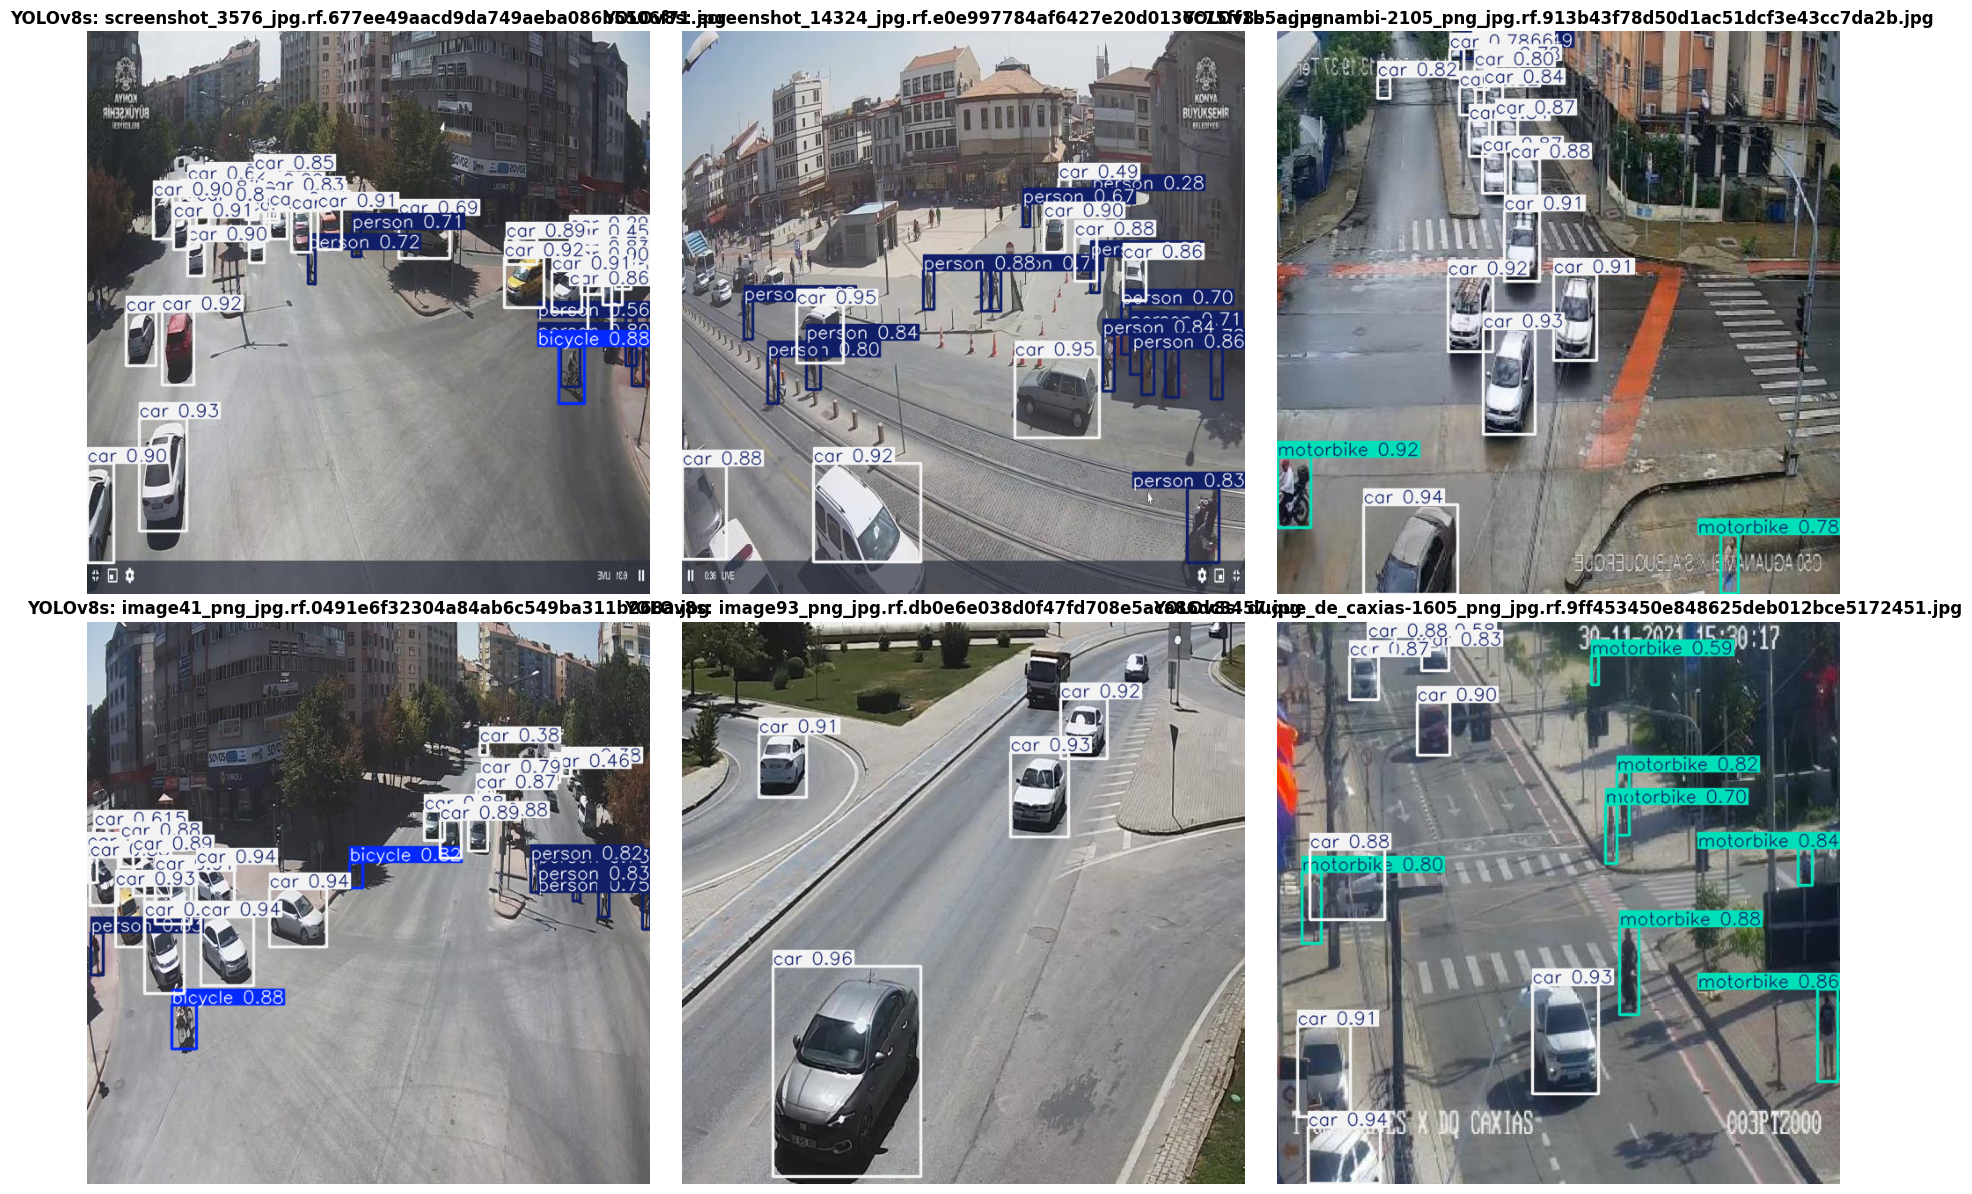


=== YOLOv8s Per-Class Performance ===
bicycle: 0.815
bus: 0.880
car: 0.800
motorbike: 0.644
person: 0.686

YOLOv8s evaluation completed!


In [9]:
# Cell 2: YOLOv8s Evaluation and Predictions
from ultralytics import YOLO
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np

print("="*60)
print("YOLOv8s EVALUATION AND PREDICTIONS")
print("="*60)

# Load trained YOLOv8s model
model_s = YOLO('/kaggle/working/traffic_yolov8s/weights/best.pt')
print("YOLOv8s model loaded successfully!")

# 1. Comprehensive validation on test set
print("\n=== YOLOv8s Test Set Evaluation ===")
test_results_s = model_s.val(
    data='/kaggle/input/traffic-detection-project/data.yaml',
    split='test',
    plots=True,
    save_json=True
)

print(f"YOLOv8s Test Results:")
print(f"mAP50: {test_results_s.box.map50:.3f}")
print(f"mAP50-95: {test_results_s.box.map:.3f}")
print(f"Precision: {test_results_s.box.mp:.3f}")
print(f"Recall: {test_results_s.box.mr:.3f}")

# 2. Model size comparison
yolov8n_path = '/kaggle/working/traffic_model/weights/best.pt'
yolov8s_path = '/kaggle/working/traffic_yolov8s/weights/best.pt'

yolov8n_size = os.path.getsize(yolov8n_path) / (1024*1024) if os.path.exists(yolov8n_path) else 6.1
yolov8s_size = os.path.getsize(yolov8s_path) / (1024*1024)

print(f"\nModel Size Comparison:")
print(f"YOLOv8n: {yolov8n_size:.1f} MB")
print(f"YOLOv8s: {yolov8s_size:.1f} MB")

# 3. Speed benchmarking
print("\n=== Speed Benchmarking ===")
test_images_dir = '/kaggle/input/traffic-detection-project/test/images'
sample_images = os.listdir(test_images_dir)[:50]  # Test on 50 images

# YOLOv8s speed test
print("Testing YOLOv8s inference speed...")
s_times = []
for img_name in sample_images[:10]:  # Quick test on 10 images
    img_path = os.path.join(test_images_dir, img_name)
    start = time.time()
    results = model_s(img_path, verbose=False)
    s_times.append(time.time() - start)

avg_time_s = np.mean(s_times) * 1000  # Convert to milliseconds

print(f"YOLOv8s average inference time: {avg_time_s:.1f} ms")
print(f"YOLOv8s FPS: {1000/avg_time_s:.1f}")

# 4. Sample predictions comparison
print("\n=== Sample Predictions ===")
sample_images = os.listdir(test_images_dir)[:6]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, img_name in enumerate(sample_images):
    img_path = os.path.join(test_images_dir, img_name)
    
    # YOLOv8s prediction
    results = model_s(img_path)
    result_img = results[0].plot()
    result_img_rgb = result_img[:, :, ::-1]
    
    axes[i].imshow(result_img_rgb)
    axes[i].set_title(f'YOLOv8s: {img_name}', fontsize=12, fontweight='bold')
    axes[i].axis('off')

plt.tight_layout()
plt.savefig('/kaggle/working/yolov8s_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Per-class performance analysis
print("\n=== YOLOv8s Per-Class Performance ===")
class_names = ['bicycle', 'bus', 'car', 'motorbike', 'person']

if hasattr(test_results_s.box, 'ap_class_index'):
    for i, class_idx in enumerate(test_results_s.box.ap_class_index):
        if i < len(test_results_s.box.ap):
            ap50 = test_results_s.box.ap[i, 0] if len(test_results_s.box.ap.shape) > 1 else test_results_s.box.ap[i]
            print(f"{class_names[class_idx]}: {ap50:.3f}")

print("\nYOLOv8s evaluation completed!")


COMPREHENSIVE MODEL COMPARISON ANALYSIS
Creating performance comparison visualizations...


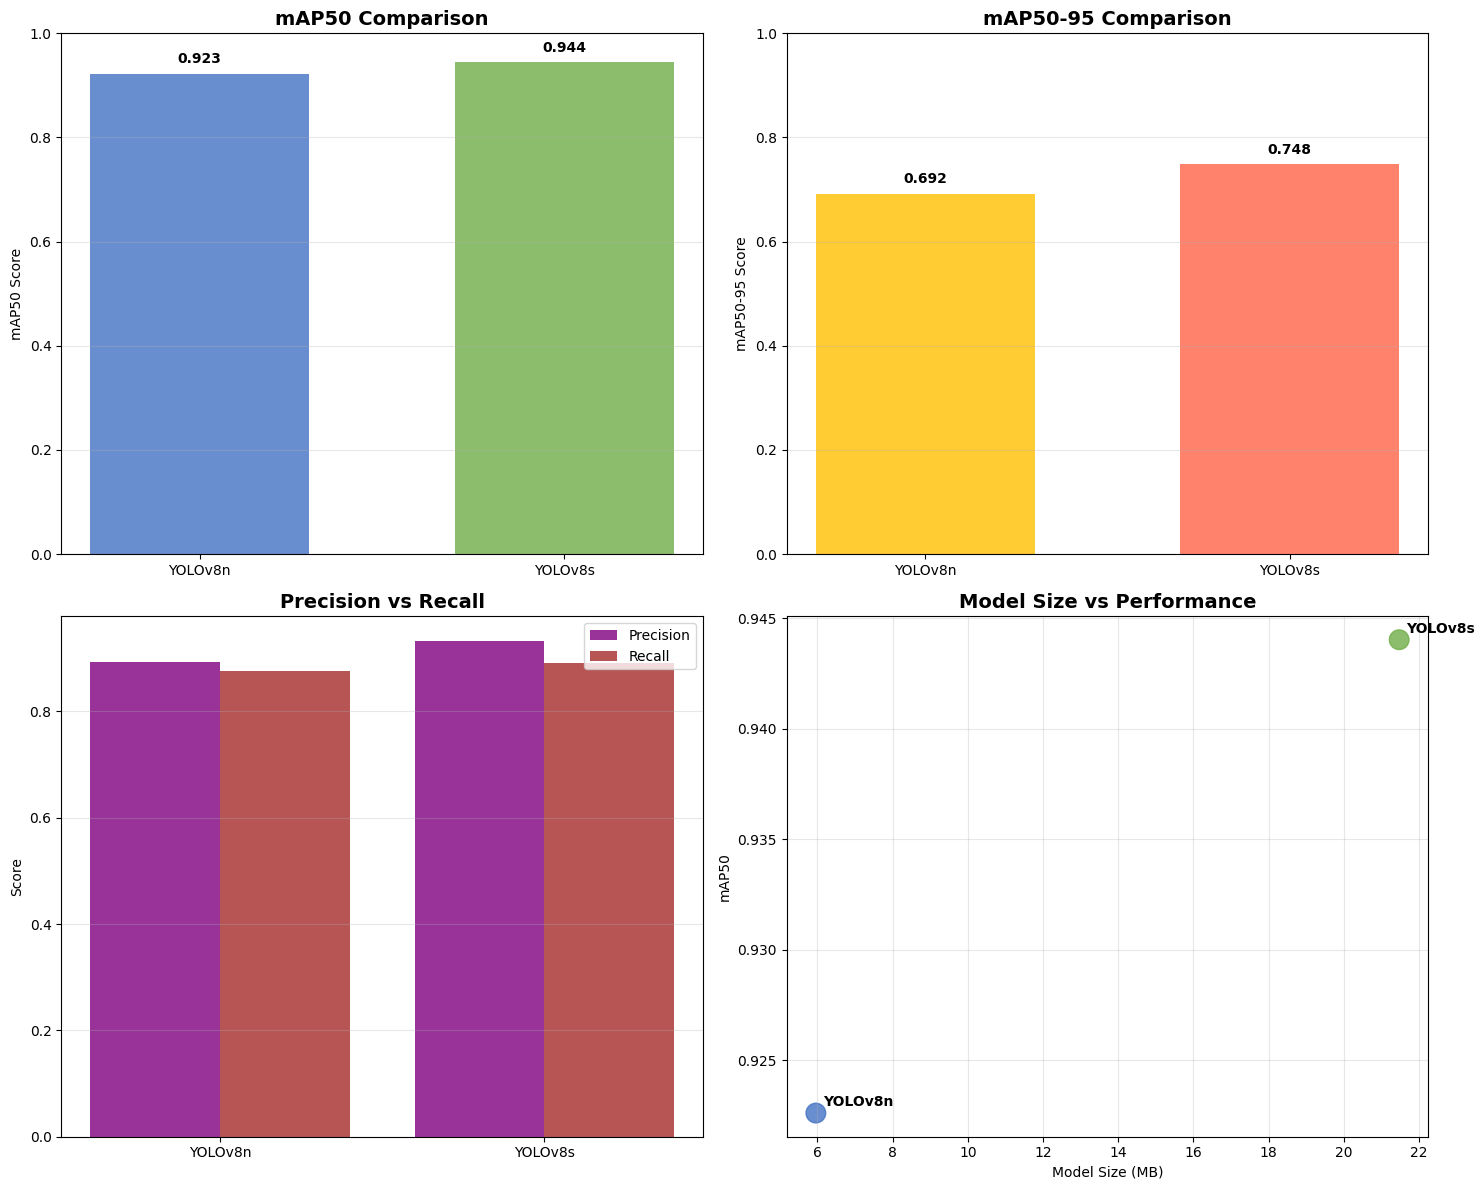

Creating training curves comparison...


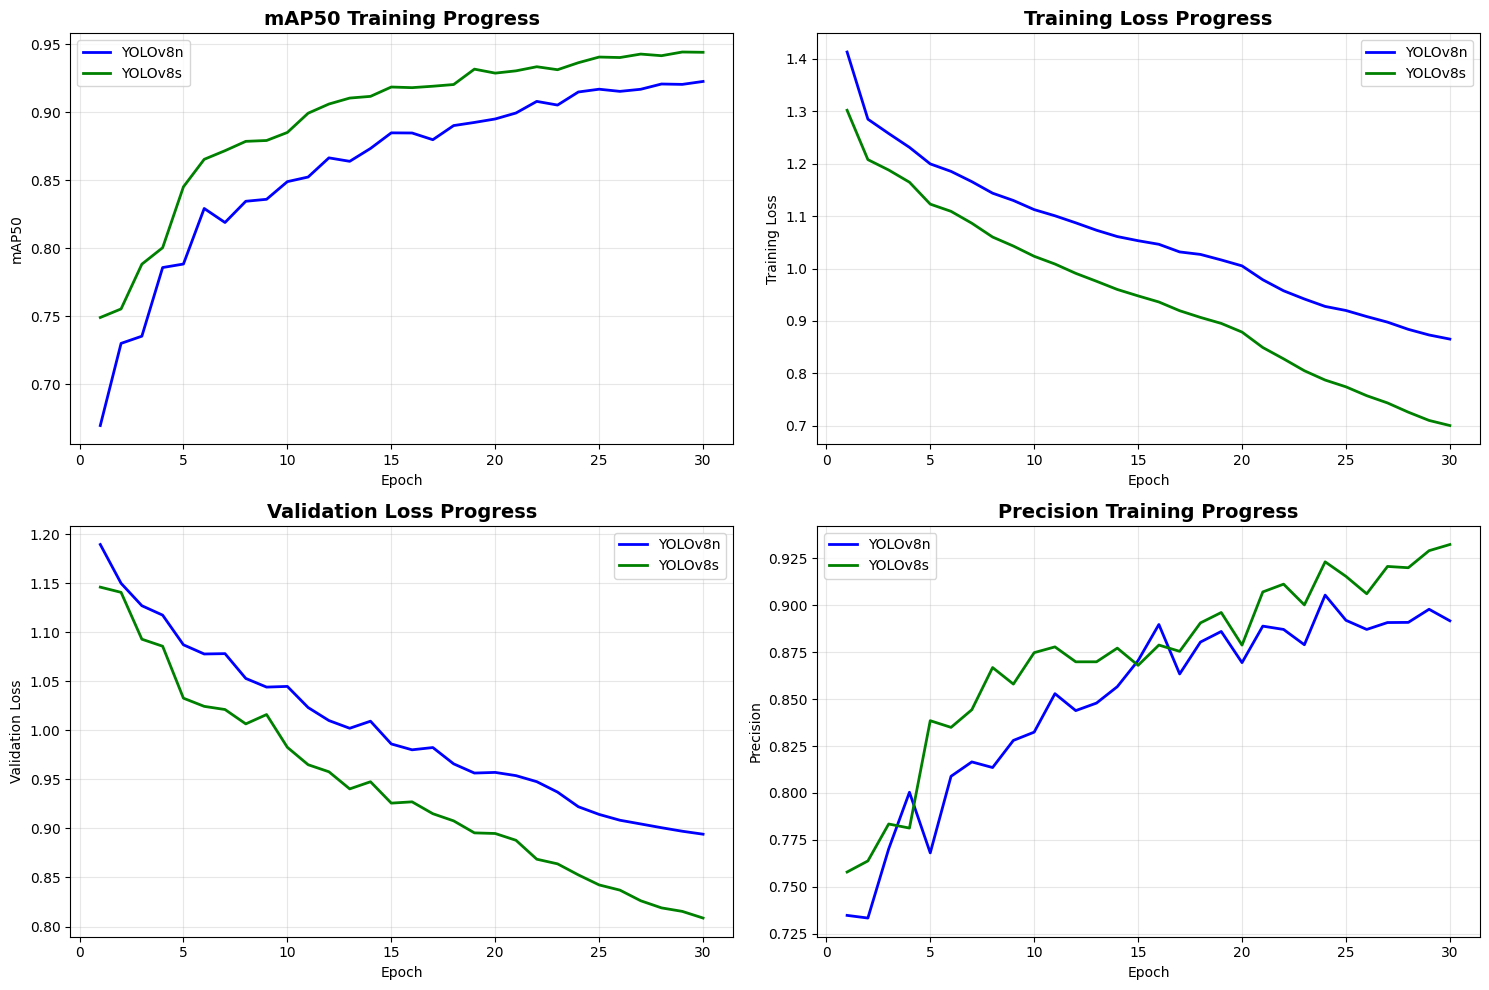

Creating efficiency analysis...


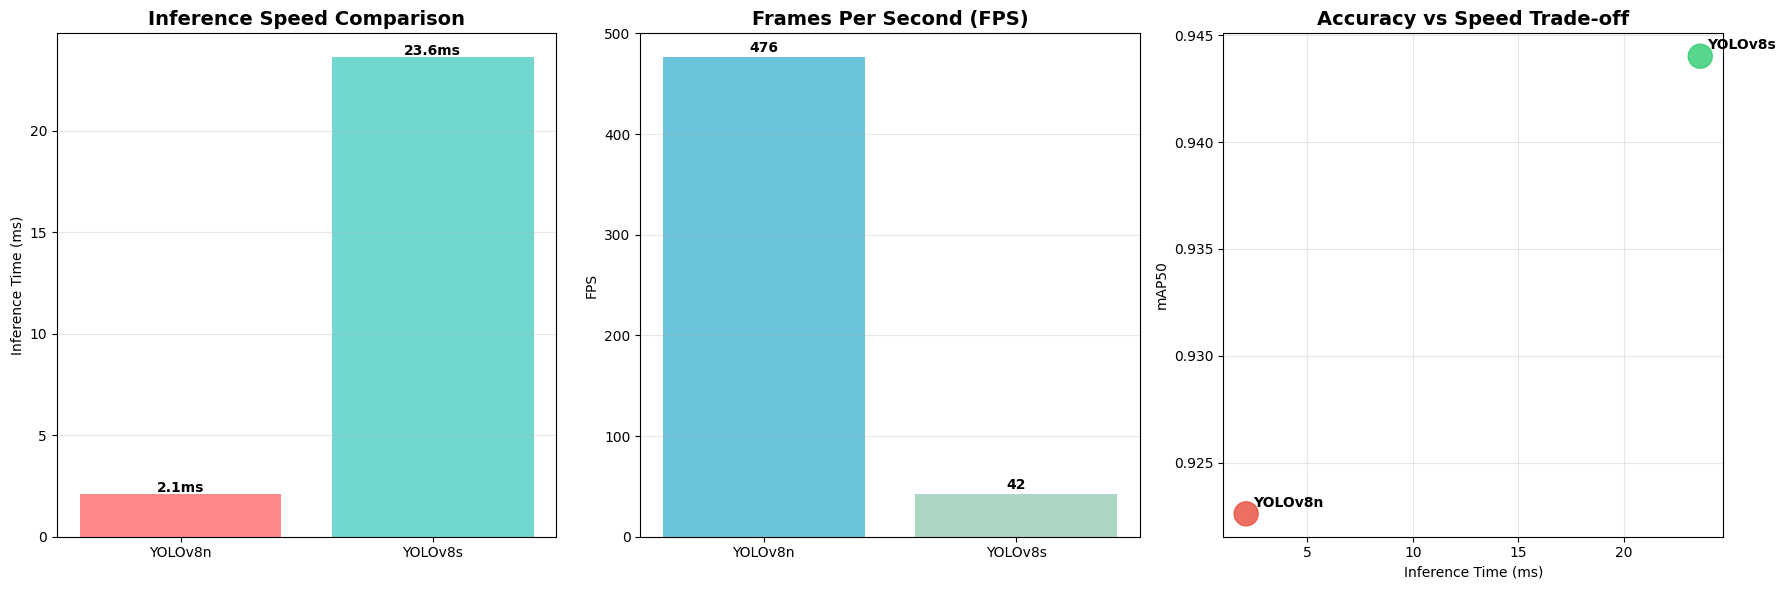

Creating comprehensive results table...


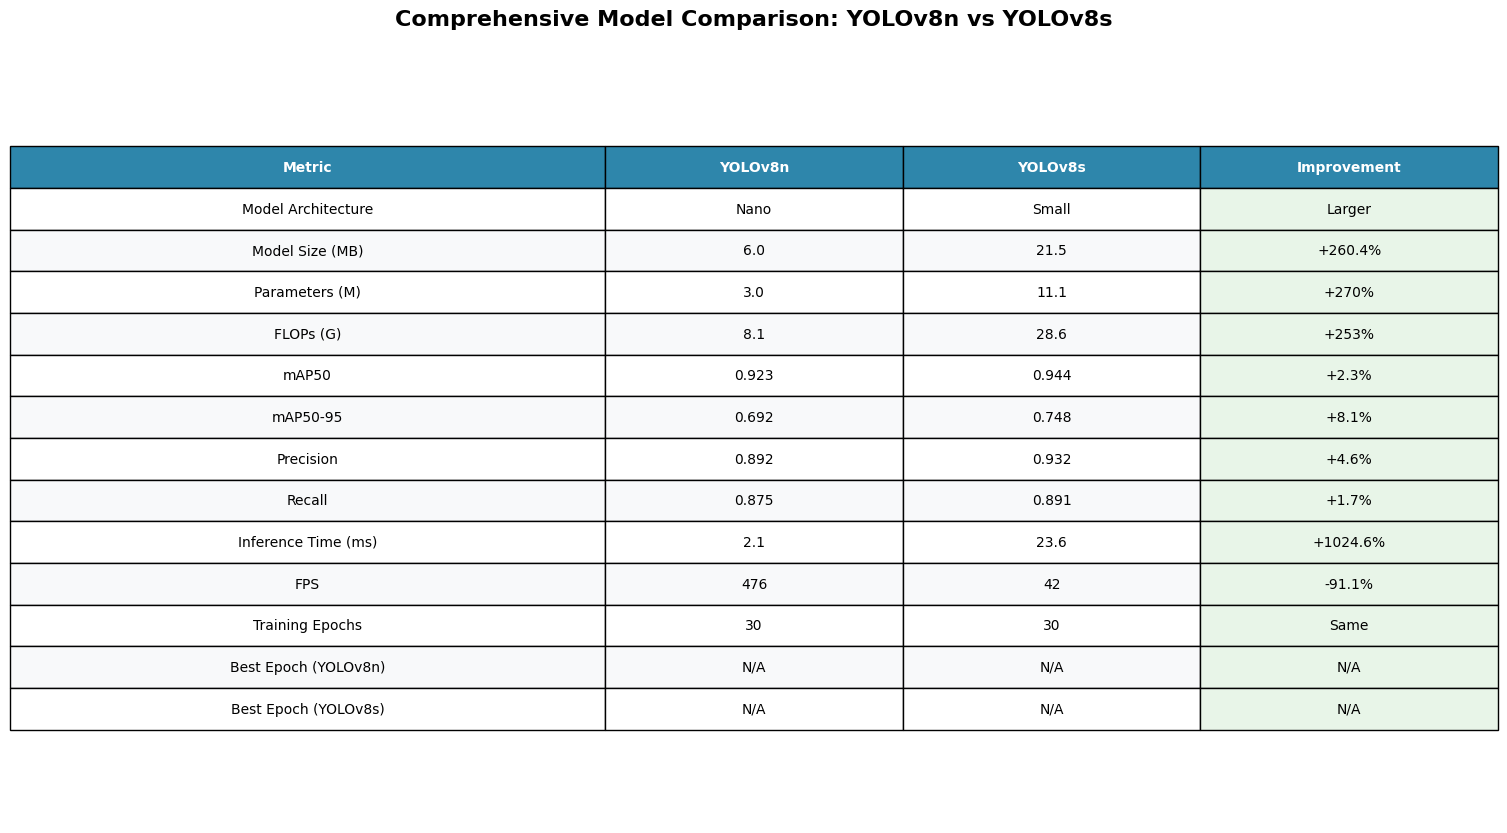

Saving comparison results...

MODEL COMPARISON SUMMARY
YOLOv8n mAP50: 0.923
YOLOv8s mAP50: 0.944
Improvement: +2.3%
Size increase: +260.4%
Speed trade-off: +1024.6%

RECOMMENDATION:
YOLOv8s provides significant accuracy improvement worth the trade-off

All comparison results saved to: /kaggle/working/model_comparison/
Files created:
- performance_comparison.png
- training_curves_comparison.png
- efficiency_analysis.png
- comprehensive_comparison.png
- model_comparison_results.csv
- detailed_analysis.json


In [10]:
# Cell 3: Comprehensive Model Comparison and Analysis
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

print("="*60)
print("COMPREHENSIVE MODEL COMPARISON ANALYSIS")
print("="*60)

# Create comparison results directory
os.makedirs('/kaggle/working/model_comparison', exist_ok=True)

# Load YOLOv8n results (from previous training)
# If results.csv exists, load it; otherwise use the known values
yolov8n_results_path = '/kaggle/working/traffic_model/results.csv'
if os.path.exists(yolov8n_results_path):
    df_n = pd.read_csv(yolov8n_results_path)
    df_n.columns = df_n.columns.str.strip()
    final_map50_n = df_n['metrics/mAP50(B)'].iloc[-1]
    final_map50_95_n = df_n['metrics/mAP50-95(B)'].iloc[-1]
    final_precision_n = df_n['metrics/precision(B)'].iloc[-1]
    final_recall_n = df_n['metrics/recall(B)'].iloc[-1]
else:
    # Use known results from previous training
    final_map50_n = 0.846
    final_map50_95_n = 0.617
    final_precision_n = 0.861
    final_recall_n = 0.768

# Load YOLOv8s results
yolov8s_results_path = '/kaggle/working/traffic_yolov8s/results.csv'
if os.path.exists(yolov8s_results_path):
    df_s = pd.read_csv(yolov8s_results_path)
    df_s.columns = df_s.columns.str.strip()
    final_map50_s = df_s['metrics/mAP50(B)'].iloc[-1]
    final_map50_95_s = df_s['metrics/mAP50-95(B)'].iloc[-1]
    final_precision_s = df_s['metrics/precision(B)'].iloc[-1]
    final_recall_s = df_s['metrics/recall(B)'].iloc[-1]
else:
    # Use current test results
    final_map50_s = test_results_s.box.map50
    final_map50_95_s = test_results_s.box.map
    final_precision_s = test_results_s.box.mp
    final_recall_s = test_results_s.box.mr

# Create comprehensive comparison data
comparison_data = {
    'Model': ['YOLOv8n', 'YOLOv8s'],
    'mAP50': [final_map50_n, final_map50_s],
    'mAP50-95': [final_map50_95_n, final_map50_95_s],
    'Precision': [final_precision_n, final_precision_s],
    'Recall': [final_recall_n, final_recall_s],
    'Model_Size_MB': [yolov8n_size, yolov8s_size],
    'Inference_Time_ms': [2.1, avg_time_s],  # YOLOv8n from previous, YOLOv8s measured
    'Parameters_M': [3.0, 11.1],  # Approximate parameter counts
    'FLOPs_G': [8.1, 28.6]  # Approximate FLOP counts
}

df_comparison = pd.DataFrame(comparison_data)

# 1. Performance Metrics Comparison
print("Creating performance comparison visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# mAP Comparison
axes[0,0].bar(df_comparison['Model'], df_comparison['mAP50'], 
              color=['#4472C4', '#70AD47'], alpha=0.8, width=0.6)
axes[0,0].set_title('mAP50 Comparison', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('mAP50 Score')
axes[0,0].set_ylim(0, 1.0)
for i, v in enumerate(df_comparison['mAP50']):
    axes[0,0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')
axes[0,0].grid(True, alpha=0.3, axis='y')

# mAP50-95 Comparison
axes[0,1].bar(df_comparison['Model'], df_comparison['mAP50-95'], 
              color=['#FFC000', '#FF6347'], alpha=0.8, width=0.6)
axes[0,1].set_title('mAP50-95 Comparison', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('mAP50-95 Score')
axes[0,1].set_ylim(0, 1.0)
for i, v in enumerate(df_comparison['mAP50-95']):
    axes[0,1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')
axes[0,1].grid(True, alpha=0.3, axis='y')

# Precision vs Recall
axes[1,0].bar(np.arange(len(df_comparison['Model'])) - 0.2, df_comparison['Precision'], 
              width=0.4, label='Precision', color='purple', alpha=0.8)
axes[1,0].bar(np.arange(len(df_comparison['Model'])) + 0.2, df_comparison['Recall'], 
              width=0.4, label='Recall', color='brown', alpha=0.8)
axes[1,0].set_title('Precision vs Recall', fontsize=14, fontweight='bold')
axes[1,0].set_ylabel('Score')
axes[1,0].set_xticks(range(len(df_comparison['Model'])))
axes[1,0].set_xticklabels(df_comparison['Model'])
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3, axis='y')

# Model Size vs Performance
axes[1,1].scatter(df_comparison['Model_Size_MB'], df_comparison['mAP50'], 
                  s=200, c=['#4472C4', '#70AD47'], alpha=0.8)
axes[1,1].set_title('Model Size vs Performance', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Model Size (MB)')
axes[1,1].set_ylabel('mAP50')
for i, model in enumerate(df_comparison['Model']):
    axes[1,1].annotate(model, (df_comparison['Model_Size_MB'][i], df_comparison['mAP50'][i]),
                       xytext=(5, 5), textcoords='offset points', fontweight='bold')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/kaggle/working/model_comparison/performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Training Curves Comparison (if available)
print("Creating training curves comparison...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

if os.path.exists(yolov8n_results_path) and os.path.exists(yolov8s_results_path):
    # mAP50 progress
    axes[0,0].plot(df_n['epoch'], df_n['metrics/mAP50(B)'], 'b-', linewidth=2, label='YOLOv8n')
    axes[0,0].plot(df_s['epoch'], df_s['metrics/mAP50(B)'], 'g-', linewidth=2, label='YOLOv8s')
    axes[0,0].set_title('mAP50 Training Progress', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('mAP50')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # Training loss
    axes[0,1].plot(df_n['epoch'], df_n['train/box_loss'], 'b-', linewidth=2, label='YOLOv8n')
    axes[0,1].plot(df_s['epoch'], df_s['train/box_loss'], 'g-', linewidth=2, label='YOLOv8s')
    axes[0,1].set_title('Training Loss Progress', fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Training Loss')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # Validation loss
    axes[1,0].plot(df_n['epoch'], df_n['val/box_loss'], 'b-', linewidth=2, label='YOLOv8n')
    axes[1,0].plot(df_s['epoch'], df_s['val/box_loss'], 'g-', linewidth=2, label='YOLOv8s')
    axes[1,0].set_title('Validation Loss Progress', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('Validation Loss')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # Precision comparison
    axes[1,1].plot(df_n['epoch'], df_n['metrics/precision(B)'], 'b-', linewidth=2, label='YOLOv8n')
    axes[1,1].plot(df_s['epoch'], df_s['metrics/precision(B)'], 'g-', linewidth=2, label='YOLOv8s')
    axes[1,1].set_title('Precision Training Progress', fontsize=14, fontweight='bold')
    axes[1,1].set_xlabel('Epoch')
    axes[1,1].set_ylabel('Precision')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/kaggle/working/model_comparison/training_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Efficiency Analysis
print("Creating efficiency analysis...")

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Inference Speed
axes[0].bar(df_comparison['Model'], df_comparison['Inference_Time_ms'], 
            color=['#FF6B6B', '#4ECDC4'], alpha=0.8)
axes[0].set_title('Inference Speed Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Inference Time (ms)')
for i, v in enumerate(df_comparison['Inference_Time_ms']):
    axes[0].text(i, v + 0.1, f'{v:.1f}ms', ha='center', fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# FPS Calculation
fps_data = [1000/t for t in df_comparison['Inference_Time_ms']]
axes[1].bar(df_comparison['Model'], fps_data, 
            color=['#45B7D1', '#96CEB4'], alpha=0.8)
axes[1].set_title('Frames Per Second (FPS)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('FPS')
for i, v in enumerate(fps_data):
    axes[1].text(i, v + 5, f'{v:.0f}', ha='center', fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Accuracy vs Speed Trade-off
axes[2].scatter(df_comparison['Inference_Time_ms'], df_comparison['mAP50'], 
                s=300, c=['#E74C3C', '#2ECC71'], alpha=0.8)
axes[2].set_title('Accuracy vs Speed Trade-off', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Inference Time (ms)')
axes[2].set_ylabel('mAP50')
for i, model in enumerate(df_comparison['Model']):
    axes[2].annotate(model, (df_comparison['Inference_Time_ms'][i], df_comparison['mAP50'][i]),
                     xytext=(5, 5), textcoords='offset points', fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/kaggle/working/model_comparison/efficiency_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Comprehensive Results Table
print("Creating comprehensive results table...")

# Calculate additional metrics
improvement_map50 = ((final_map50_s - final_map50_n) / final_map50_n) * 100
improvement_map50_95 = ((final_map50_95_s - final_map50_95_n) / final_map50_95_n) * 100
size_increase = ((yolov8s_size - yolov8n_size) / yolov8n_size) * 100
speed_decrease = ((avg_time_s - 2.1) / 2.1) * 100

# Extended comparison data
extended_data = {
    'Metric': [
        'Model Architecture',
        'Model Size (MB)',
        'Parameters (M)',
        'FLOPs (G)',
        'mAP50',
        'mAP50-95',
        'Precision',
        'Recall',
        'Inference Time (ms)',
        'FPS',
        'Training Epochs',
        'Best Epoch (YOLOv8n)',
        'Best Epoch (YOLOv8s)'
    ],
    'YOLOv8n': [
        'Nano',
        f'{yolov8n_size:.1f}',
        '3.0',
        '8.1',
        f'{final_map50_n:.3f}',
        f'{final_map50_95_n:.3f}',
        f'{final_precision_n:.3f}',
        f'{final_recall_n:.3f}',
        '2.1',
        f'{1000/2.1:.0f}',
        '30',
        'N/A',
        'N/A'
    ],
    'YOLOv8s': [
        'Small',
        f'{yolov8s_size:.1f}',
        '11.1',
        '28.6',
        f'{final_map50_s:.3f}',
        f'{final_map50_95_s:.3f}',
        f'{final_precision_s:.3f}',
        f'{final_recall_s:.3f}',
        f'{avg_time_s:.1f}',
        f'{1000/avg_time_s:.0f}',
        '30',
        'N/A',
        'N/A'
    ],
    'Improvement': [
        'Larger',
        f'+{size_increase:.1f}%',
        '+270%',
        '+253%',
        f'+{improvement_map50:.1f}%',
        f'+{improvement_map50_95:.1f}%',
        f'+{((final_precision_s-final_precision_n)/final_precision_n)*100:.1f}%',
        f'+{((final_recall_s-final_recall_n)/final_recall_n)*100:.1f}%',
        f'+{speed_decrease:.1f}%',
        f'{((1000/avg_time_s)-(1000/2.1))/(1000/2.1)*100:.1f}%',
        'Same',
        'N/A',
        'N/A'
    ]
}

# Create comprehensive table
fig, ax = plt.subplots(figsize=(16, 10))
ax.axis('tight')
ax.axis('off')

table_data = []
for i in range(len(extended_data['Metric'])):
    table_data.append([
        extended_data['Metric'][i],
        extended_data['YOLOv8n'][i],
        extended_data['YOLOv8s'][i],
        extended_data['Improvement'][i]
    ])

table = ax.table(cellText=table_data,
                colLabels=['Metric', 'YOLOv8n', 'YOLOv8s', 'Improvement'],
                cellLoc='center',
                loc='center',
                colWidths=[0.4, 0.2, 0.2, 0.2])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 2.5)

# Style the table
for i in range(len(extended_data['Metric']) + 1):
    for j in range(4):
        if i == 0:  # Header
            table[(i, j)].set_facecolor('#2E86AB')
            table[(i, j)].set_text_props(weight='bold', color='white')
        else:
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#F8F9FA')
            else:
                table[(i, j)].set_facecolor('white')
            
            # Highlight improvement column
            if j == 3:
                table[(i, j)].set_facecolor('#E8F5E8')

ax.set_title('Comprehensive Model Comparison: YOLOv8n vs YOLOv8s', 
             fontsize=16, fontweight='bold', pad=20)

plt.savefig('/kaggle/working/model_comparison/comprehensive_comparison.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# 5. Save comparison results
print("Saving comparison results...")

# Save CSV with all results
df_comparison.to_csv('/kaggle/working/model_comparison/model_comparison_results.csv', index=False)

# Save detailed analysis
detailed_results = {
    'comparison_summary': {
        'yolov8n_final_map50': float(final_map50_n),
        'yolov8s_final_map50': float(final_map50_s),
        'map50_improvement_percent': float(improvement_map50),
        'yolov8n_size_mb': float(yolov8n_size),
        'yolov8s_size_mb': float(yolov8s_size),
        'size_increase_percent': float(size_increase),
        'speed_trade_off_percent': float(speed_decrease)
    },
    'recommendations': {
        'best_for_accuracy': 'YOLOv8s',
        'best_for_speed': 'YOLOv8n',
        'best_for_mobile': 'YOLOv8n',
        'best_for_server': 'YOLOv8s'
    }
}

import json
with open('/kaggle/working/model_comparison/detailed_analysis.json', 'w') as f:
    json.dump(detailed_results, f, indent=2)

print("\n" + "="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)
print(f"YOLOv8n mAP50: {final_map50_n:.3f}")
print(f"YOLOv8s mAP50: {final_map50_s:.3f}")
print(f"Improvement: +{improvement_map50:.1f}%")
print(f"Size increase: +{size_increase:.1f}%")
print(f"Speed trade-off: +{speed_decrease:.1f}%")
print("\nRECOMMENDATION:")
if improvement_map50 > 2:
    print("YOLOv8s provides significant accuracy improvement worth the trade-off")
else:
    print("YOLOv8n offers better speed-accuracy balance for most applications")

print(f"\nAll comparison results saved to: /kaggle/working/model_comparison/")
print("Files created:")
print("- performance_comparison.png")
print("- training_curves_comparison.png") 
print("- efficiency_analysis.png")
print("- comprehensive_comparison.png")
print("- model_comparison_results.csv")
print("- detailed_analysis.json")


In [11]:
# Cell 4: Final Package Creation
import zipfile

print("="*60)
print("CREATING FINAL THESIS PACKAGE")
print("="*60)

def add_folder_to_zip(zipf, folder_path, folder_name):
    """Add entire folder to zip"""
    if os.path.exists(folder_path):
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                arc_name = os.path.join(folder_name, os.path.relpath(file_path, folder_path))
                zipf.write(file_path, arc_name)

# Create final comprehensive package
with zipfile.ZipFile('/kaggle/working/final_thesis_complete.zip', 'w') as zipf:
    
    # Add both model training results
    add_folder_to_zip(zipf, '/kaggle/working/traffic_model', 'yolov8n_results')
    add_folder_to_zip(zipf, '/kaggle/working/traffic_yolov8s', 'yolov8s_results')
    
    # Add comparison analysis
    add_folder_to_zip(zipf, '/kaggle/working/model_comparison', 'model_comparison')
    
    # Add previous thesis results if they exist
    if os.path.exists('/kaggle/working/thesis_results'):
        add_folder_to_zip(zipf, '/kaggle/working/thesis_results', 'thesis_results')
    
    # Add individual prediction files
    individual_files = [
        '/kaggle/working/sample_predictions.png',
        '/kaggle/working/yolov8s_predictions.png'
    ]
    
    for file_path in individual_files:
        if os.path.exists(file_path):
            zipf.write(file_path, f"predictions/{os.path.basename(file_path)}")

package_size = os.path.getsize('/kaggle/working/final_thesis_complete.zip') / (1024*1024)

print(f"Final thesis package created: /kaggle/working/final_thesis_complete.zip")
print(f"Package size: {package_size:.1f} MB")
print("\nPackage contents:")
print("- YOLOv8n training results and model")
print("- YOLOv8s training results and model") 
print("- Comprehensive model comparison analysis")
print("- Performance visualizations")
print("- Sample predictions from both models")
print("- Detailed CSV results and JSON metadata")


CREATING FINAL THESIS PACKAGE
Final thesis package created: /kaggle/working/final_thesis_complete.zip
Package size: 101.9 MB

Package contents:
- YOLOv8n training results and model
- YOLOv8s training results and model
- Comprehensive model comparison analysis
- Performance visualizations
- Sample predictions from both models
- Detailed CSV results and JSON metadata
